# Setup

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="4"
os.environ["CUDA_LAUNCH_BLOCKING"]="1, 2, 3, 4"

In [2]:
import numpy as np
import pandas as pd

from sklearn.metrics.pairwise import cosine_similarity

In [3]:
import torch
from sklearn.preprocessing import normalize
from torch.utils.data import Dataset, DataLoader
from torchsampler import ImbalancedDatasetSampler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score

# Import Data

In [4]:
items = pd.read_csv("../Datasets/ml-100k/Text/items.csv")

r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('../Datasets/ml-100k/Text/u1.base', sep='\t', names=r_cols,encoding='latin-1')

In [5]:
# n_users = ratings.user_id.unique().shape[0]
# n_items = ratings.movie_id.unique().shape[0]
n_users = 943
n_items = 1682

In [6]:
data_matrix = np.zeros((n_users, n_items))
for line in ratings.itertuples():
    data_matrix[line[1]-1, line[2]-1] = line[3]

In [7]:
data_matrix_emp = data_matrix.copy()
data_matrix_emp[data_matrix < 4] = 0
data_matrix_emp[data_matrix >= 4]= 1 

In [8]:
train_indices = list(zip(*(np.where(data_matrix != 0))))

In [9]:
len(train_indices)

80000

# Siamese network

## Data loader

In [10]:
torch.cuda.is_available()

True

In [11]:
torch.__version__

'1.10.1'

In [12]:
items_csv = "../Datasets/ml-100k/Text/items.csv"
train_ratings = "../Datasets/ml-100k/Text/u1.base"
test_ratings = "../Datasets/ml-100k/Text/u1.test"

item_path = "../Datasets/ml-100k/Text/embeddings_compressed.csv"

# item_path = "item.csv"
user_path = "user.csv"

In [13]:
pd.read_csv(user_path)

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,-0.002777,0.133102,-0.000427,-0.000499,-0.000466,-0.000832,-0.000081,-0.000320,-0.001322,-0.000568,...,-0.000275,-0.001560,0.489732,-0.000981,-0.000686,-0.003094,-0.000294,-0.000514,-0.000571,-0.000156
1,-0.008771,0.366939,-0.001604,-0.002249,-0.001698,-0.003220,-0.000328,0.138042,-0.003031,0.467104,...,0.229866,-0.001257,1.987406,-0.003631,0.666453,-0.011405,-0.000329,0.529317,0.070467,0.165439
2,-0.005561,-0.003085,-0.001666,-0.002197,-0.001780,-0.003350,-0.000344,0.269559,-0.002961,0.760151,...,0.369748,0.123917,1.276766,-0.003779,1.057301,-0.011673,-0.000348,0.907381,0.199681,0.260925
3,-0.008630,0.621194,-0.001155,-0.001561,-0.001222,-0.002320,-0.000232,0.027952,-0.002570,0.134248,...,0.065190,-0.002695,1.524815,-0.002617,0.199068,-0.008342,-0.000330,0.154600,-0.000251,0.049998
4,-0.005992,0.508465,-0.000626,-0.000840,-0.000668,-0.001246,-0.000124,-0.000511,-0.001689,-0.000861,...,-0.000439,-0.002693,0.967604,-0.001424,-0.001116,-0.004593,-0.000253,-0.000893,-0.000969,-0.000249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,-0.004862,-0.006177,-0.001971,-0.002638,-0.002108,-0.003962,-0.000411,0.374273,-0.003213,1.055057,...,0.514456,0.289644,1.422936,-0.004468,1.464880,-0.013707,-0.000336,1.248008,0.295436,0.363475
939,-0.002549,-0.003143,-0.001116,-0.001401,-0.001207,-0.002238,-0.000229,0.194666,-0.002043,0.525443,...,0.260036,0.128470,0.711413,-0.002545,0.729693,-0.007782,-0.000321,0.628858,0.151933,0.185511
940,-0.005642,-0.002874,-0.001662,-0.002192,-0.001775,-0.003342,-0.000343,0.266110,-0.002961,0.750940,...,0.365410,0.116804,1.287590,-0.003771,1.044818,-0.011651,-0.000348,0.895617,0.197078,0.257924
941,-0.002615,-0.004317,-0.001258,-0.001595,-0.001358,-0.002524,-0.000260,0.235185,-0.002214,0.637353,...,0.313594,0.176814,0.761069,-0.002865,0.883903,-0.008751,-0.000320,0.763316,0.186613,0.222493


In [14]:
cosine_similarity(np.nan_to_num(pd.read_csv(item_path)))

array([[1.        , 0.54148059, 0.54101969, ..., 0.87055876, 0.52666861,
        0.54745216],
       [0.54148059, 1.        , 0.99999804, ..., 0.70458299, 0.99974741,
        0.99992643],
       [0.54101969, 0.99999804, 1.        , ..., 0.70404377, 0.9997639 ,
        0.99992708],
       ...,
       [0.87055876, 0.70458299, 0.70404377, ..., 1.        , 0.68851079,
        0.71184059],
       [0.52666861, 0.99974741, 0.9997639 , ..., 0.68851079, 1.        ,
        0.99944335],
       [0.54745216, 0.99992643, 0.99992708, ..., 0.71184059, 0.99944335,
        1.        ]])

In [15]:
cosine_similarity(pd.read_csv(user_path))

array([[1.        , 0.69819409, 0.34263208, ..., 0.34849673, 0.24775103,
        0.22089895],
       [0.69819409, 1.        , 0.88973318, ..., 0.89315   , 0.82885669,
        0.8061673 ],
       [0.34263208, 0.88973318, 1.        , ..., 0.99996599, 0.99162816,
        0.98459626],
       ...,
       [0.34849673, 0.89315   , 0.99996599, ..., 1.        , 0.99055261,
        0.98319433],
       [0.24775103, 0.82885669, 0.99162816, ..., 0.99055261, 1.        ,
        0.99806179],
       [0.22089895, 0.8061673 , 0.98459626, ..., 0.98319433, 0.99806179,
        1.        ]])

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
class MovielensDataset(Dataset):
    def __init__(self, items_csv = items_csv, ratings = train_ratings, 
                 user_path = user_path, item_path = item_path, device = device):
        self.items = pd.read_csv(items_csv).to_numpy()
        self.item_embeddings = pd.read_csv(item_path).to_numpy()
        self.user_embeddings = pd.read_csv(user_path).to_numpy()
        self.ratings = pd.read_csv(ratings, sep='\t', 
                                   names=['user_id', 'movie_id', 'rating', 'unix_timestamp'],encoding='latin-1')
        self.indices = None
        self.device = device
        self.data = None
        self.n_users = None
        self.n_items = None
        self.fill_ratings()
        self.embeddings()
    
    def fill_ratings(self, threshold=4):
        self.n_users = self.ratings.user_id.unique().shape[0]
        self.n_items = self.ratings.movie_id.unique().shape[0]
        
        self.data = np.zeros((n_users, n_items))
        for line in self.ratings.itertuples():
            self.data[line[1]-1, line[2]-1] = line[3]
            
        self.indices = list(zip(*(np.where(self.data != 0))))
            
    def embeddings(self):
#         self.item_embeddings = np.nan_to_num(self.item_embeddings)
#         self.item_embeddings = normalize(self.item_embeddings)
#         self.item_embeddings = np.append(data_matrix.T, self.item_embeddings, axis = 1)
        self.user_embeddings = data_matrix
#         self.user_embeddings = normalize(self.user_embeddings)
        self.item_embedding_size = self.item_embeddings.shape[1]
        self.user_embedding_size = self.user_embeddings.shape[1]
        
    def __len__(self):
        return(len(self.indices))
    
    def __getitem__(self, idx):
        user = self.indices[idx][0]
        item = self.indices[idx][1]

        x1 = torch.from_numpy(self.user_embeddings[user]).to(self.device)
        x2 = torch.from_numpy(self.item_embeddings[item]).to(self.device)
        
        y = self.data[user][item]
        return(x1.float(), x2.float(), int(y))

In [18]:
train_dataset = MovielensDataset(ratings = train_ratings)
test_dataset = MovielensDataset(ratings = test_ratings)

# train_size = int(0.8 * len(dataset))
# test_size = len(dataset) - train_size
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [19]:
target = [int(data_matrix[train_dataset.indices[i][0]][train_dataset.indices[i][1]]) - 1 for i in range(len(train_dataset))]

In [20]:
class_sample_count = np.unique(data_matrix, return_counts=True)[1][1::]

weights = 1 / torch.Tensor(class_sample_count)
weights = weights.double()
weights_all = weights[target]

In [21]:
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights_all, len(weights_all))

In [22]:
trainloader = DataLoader(train_dataset, batch_size = 30000, shuffle = True)
testloader = DataLoader(test_dataset, batch_size = 20000, shuffle = False)

## Architecture

In [23]:
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import OrderedDict

In [24]:
from ml_metrics import mapk
from recmetrics import mark

In [25]:
class SiameseNet(nn.Module):
    def __init__(self, device = device):
        super(SiameseNet, self).__init__()
        self.encoder_user = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.user_embedding_size, 1024)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(1024, 800)),
            ('relu2', nn.LeakyReLU()),
            ('linr3', nn.Linear(800, 500)),
            ('relu3', nn.LeakyReLU()),
            ('linr4', nn.Linear(500, 100)),
            ('relu4', nn.LeakyReLU()),
        ]))
        
        self.encoder_item = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.item_embedding_size, 1600)),
            ('relu1', nn.Sigmoid()),
            ('linr2', nn.Linear(1600, 1000)),
            ('relu2', nn.ReLU()),
            ('linr3', nn.Linear(1000, 800)),
            ('relu3', nn.ReLU()),
            ('linr4', nn.Linear(800, 100)),
            ('relu4', nn.ReLU()),
#             ('linr5', nn.Linear(600, 600)),
#             ('relu5', nn.LeakyReLU()),
        ]))
        
        self.siamese = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(600, 512)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(512, 256)),
            ('relu2', nn.LeakyReLU()),
            ('linr3', nn.Linear(256, 100)),
            ('relu3', nn.LeakyReLU()),
#             ('linr4', nn.Linear(256, 100)),
#             ('relu4', nn.LeakyReLU())
        ]))
        
        self.ffn = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(200, 164)),
            ('actv1', nn.LeakyReLU()),
            ('linr2', nn.Linear(164, 50)),
            ('actv2', nn.LeakyReLU()),
#             ('linr3', nn.Linear(50, 20)),
#             ('actv3', nn.LeakyReLU()),
            ('linr4', nn.Linear(50, 1)),
        ]))
        
        self.device = device
        self.encoder_user.apply(self.init_weights)
        self.encoder_item.apply(self.init_weights)
        self.siamese.apply(self.init_weights)
        self.ffn.apply(self.init_weights)
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
#             nn.init.zeros_(m.weight)
            m.bias.data.fill_(0.01)
        
    def forward(self, x1, x2):
        out1 = self.encoder_user(x1)
        out2 = self.encoder_item(x2)
#         out1 = self.siamese(emb1)
#         out2 = self.siamese(emb2)
        diff = torch.cat((out1, out2), axis=1)
        out = self.ffn(diff)
        return(out, out1, out2)
    
    def fit(self, trainloader = trainloader, 
            testloader = testloader, epochs = 200):
        self.criterion_rate = nn.MSELoss()
        self.criterion_embd = nn.CosineEmbeddingLoss()
        self.optimizer = optim.Adam(self.parameters(), lr = 5e-4, weight_decay = 1e-4)
        
        train_loss = []
        train_f1 = []
        test_loss = []
        test_f1 = []
        for epoch in range(epochs):
            running_loss = 0.0
            running_loss_1 = 0.0
            
            for i, data in tqdm(enumerate(trainloader)):
                self.train()
                x1, x2, y = data
#                 print(y.unique(return_counts = True))
                y_flt = y.type(torch.FloatTensor).to(device)
                y_lng = torch.div(y, 4, rounding_mode="floor").to(device)
                self.optimizer.zero_grad()
                reg, out1, out2 = self.forward(x1, x2)
                loss_1 = self.criterion_rate(reg.squeeze(), y_flt)
                loss_2 = self.criterion_embd(out1, out2, y_lng * 2 - 1)
                loss = (loss_1) #+ loss_2) 
                loss.backward()
                self.optimizer.step()

                running_loss_1 += torch.sqrt(loss_1)
                running_loss += loss
            vl, vp, vr, vf, tp, tr, tf = self.evaluate()
            print('Epoch-%d: Loss = %.3f\nTrain RMSE = %.3f||Train Precision = %.3f||Train Recall = %.3f\nTest RMSE = %.3f || Test Precision = %.3f|| Test Recall = %.3f'%
                  (epoch + 1, running_loss / i, running_loss_1 / i, 
                   tp, tr, vl, vp, vr))
            train_loss.append((running_loss_1 / i).cpu().detach().numpy())
            test_loss.append(vl.cpu().detach().numpy())
            train_f1.append(tf)
            test_f1.append(vf)
        return(train_loss, test_loss, train_f1, test_f1)
            
    def evaluate(self, k = 3.35):
        self.eval()
        with torch.no_grad():
            valdata = next(iter(testloader))
            x1, x2, y = valdata
            y_flt = y.type(torch.FloatTensor).to(device)
            y_lng = torch.div(y, 4, rounding_mode="floor").to(device)
            otpt = self.forward(x1, x2)
            print(otpt[0])
            pred = (otpt[0] > k).float()
            vl = torch.sqrt(self.criterion_rate(otpt[0].squeeze(), y_flt))
            vp = precision_score(y_lng.cpu(), pred.cpu())
            vr = recall_score(y_lng.cpu(), pred.cpu())
            vf = f1_score(y_lng.cpu(), pred.cpu())
            print(classification_report(y_lng.cpu(), pred.cpu(),
                    target_names = ["0", "1"]))
            
            traindata = next(iter(trainloader))
            x1, x2, y = traindata
            y_flt = y.type(torch.FloatTensor).to(device)
            y_lng = torch.div(y, 4, rounding_mode="floor").to(device)
            otpt = self.forward(x1, x2)
            pred = (otpt[0] > k).float()
            tp = precision_score(y_lng.cpu(), pred.cpu())
            tr = recall_score(y_lng.cpu(), pred.cpu())
            tf = f1_score(y_lng.cpu(), pred.cpu())
        return(vl, vp*100, vr*100, vf*100, tp*100, tr*100, tf*100)

In [26]:
sm_net = SiameseNet()
sm_net.to(device)

SiameseNet(
  (encoder_user): Sequential(
    (linr1): Linear(in_features=500, out_features=1024, bias=True)
    (relu1): LeakyReLU(negative_slope=0.01)
    (linr2): Linear(in_features=1024, out_features=800, bias=True)
    (relu2): LeakyReLU(negative_slope=0.01)
    (linr3): Linear(in_features=800, out_features=500, bias=True)
    (relu3): LeakyReLU(negative_slope=0.01)
    (linr4): Linear(in_features=500, out_features=100, bias=True)
    (relu4): LeakyReLU(negative_slope=0.01)
  )
  (encoder_item): Sequential(
    (linr1): Linear(in_features=500, out_features=1600, bias=True)
    (relu1): Sigmoid()
    (linr2): Linear(in_features=1600, out_features=1000, bias=True)
    (relu2): ReLU()
    (linr3): Linear(in_features=1000, out_features=800, bias=True)
    (relu3): ReLU()
    (linr4): Linear(in_features=800, out_features=100, bias=True)
    (relu4): ReLU()
  )
  (siamese): Sequential(
    (linr1): Linear(in_features=600, out_features=512, bias=True)
    (relu1): LeakyReLU(negative_slop

In [27]:
train_loss, test_loss, train_f1, test_f1 = sm_net.fit()

3it [00:09,  3.18s/it]


tensor([[3.8192],
        [3.8254],
        [3.8183],
        ...,
        [4.3857],
        [4.1210],
        [5.1122]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      8765
           1       0.56      1.00      0.72     11235

    accuracy                           0.56     20000
   macro avg       0.28      0.50      0.36     20000
weighted avg       0.32      0.56      0.40     20000



/home/sriram_1801cs37/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch-1: Loss = 11.461
Train RMSE = 3.902||Train Precision = 55.553||Train Recall = 100.000
Test RMSE = 1.264 || Test Precision = 56.175|| Test Recall = 100.000


3it [00:08,  2.82s/it]


tensor([[3.2283],
        [3.2356],
        [3.2261],
        ...,
        [3.2849],
        [3.2026],
        [3.8053]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.45      0.88      0.60      8765
           1       0.65      0.17      0.27     11235

    accuracy                           0.48     20000
   macro avg       0.55      0.53      0.43     20000
weighted avg       0.56      0.48      0.41     20000

Epoch-2: Loss = 2.734
Train RMSE = 2.025||Train Precision = 66.455||Train Recall = 46.647
Test RMSE = 1.183 || Test Precision = 64.642|| Test Recall = 17.054


3it [00:08,  2.80s/it]


tensor([[3.5684],
        [3.5754],
        [3.5664],
        ...,
        [3.6098],
        [3.5576],
        [4.0451]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      8765
           1       0.56      1.00      0.72     11235

    accuracy                           0.56     20000
   macro avg       0.28      0.50      0.36     20000
weighted avg       0.32      0.56      0.40     20000

Epoch-3: Loss = 2.164
Train RMSE = 1.799||Train Precision = 54.940||Train Recall = 100.000
Test RMSE = 1.154 || Test Precision = 56.175|| Test Recall = 100.000


3it [00:08,  2.80s/it]


tensor([[3.2962],
        [3.3051],
        [3.2946],
        ...,
        [3.3045],
        [3.2568],
        [3.4597]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.46      0.88      0.60      8765
           1       0.66      0.19      0.29     11235

    accuracy                           0.49     20000
   macro avg       0.56      0.53      0.45     20000
weighted avg       0.57      0.49      0.43     20000

Epoch-4: Loss = 1.987
Train RMSE = 1.726||Train Precision = 66.239||Train Recall = 49.985
Test RMSE = 1.167 || Test Precision = 66.083|| Test Recall = 18.816


3it [00:08,  2.80s/it]


tensor([[3.6348],
        [3.6433],
        [3.6343],
        ...,
        [3.6452],
        [3.4920],
        [3.9742]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.89      0.02      0.04      8765
           1       0.57      1.00      0.72     11235

    accuracy                           0.57     20000
   macro avg       0.73      0.51      0.38     20000
weighted avg       0.71      0.57      0.43     20000

Epoch-5: Loss = 1.910
Train RMSE = 1.693||Train Precision = 55.675||Train Recall = 99.385
Test RMSE = 1.150 || Test Precision = 56.676|| Test Recall = 99.777


3it [00:08,  2.79s/it]


tensor([[3.1358],
        [3.1414],
        [3.1342],
        ...,
        [3.0804],
        [2.8448],
        [3.8001]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.45      0.90      0.60      8765
           1       0.67      0.16      0.26     11235

    accuracy                           0.48     20000
   macro avg       0.56      0.53      0.43     20000
weighted avg       0.57      0.48      0.41     20000

Epoch-6: Loss = 1.849
Train RMSE = 1.666||Train Precision = 66.957||Train Recall = 50.573
Test RMSE = 1.206 || Test Precision = 66.556|| Test Recall = 16.084


3it [00:08,  2.81s/it]


tensor([[3.5482],
        [3.5541],
        [3.5470],
        ...,
        [3.5134],
        [3.2872],
        [4.3061]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.63      0.06      0.10      8765
           1       0.57      0.97      0.72     11235

    accuracy                           0.57     20000
   macro avg       0.60      0.52      0.41     20000
weighted avg       0.60      0.57      0.45     20000

Epoch-7: Loss = 1.848
Train RMSE = 1.665||Train Precision = 56.423||Train Recall = 96.319
Test RMSE = 1.146 || Test Precision = 56.980|| Test Recall = 97.437


3it [00:08,  2.80s/it]


tensor([[3.2311],
        [3.2377],
        [3.2306],
        ...,
        [3.1149],
        [2.9477],
        [3.6598]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.46      0.88      0.60      8765
           1       0.66      0.19      0.29     11235

    accuracy                           0.49     20000
   macro avg       0.56      0.53      0.45     20000
weighted avg       0.57      0.49      0.43     20000

Epoch-8: Loss = 1.825
Train RMSE = 1.655||Train Precision = 66.228||Train Recall = 51.007
Test RMSE = 1.175 || Test Precision = 66.402|| Test Recall = 18.611


3it [00:08,  2.79s/it]


tensor([[3.5521],
        [3.5585],
        [3.5521],
        ...,
        [3.4737],
        [3.3451],
        [3.8727]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.70      0.03      0.07      8765
           1       0.57      0.99      0.72     11235

    accuracy                           0.57     20000
   macro avg       0.63      0.51      0.39     20000
weighted avg       0.62      0.57      0.43     20000

Epoch-9: Loss = 1.813
Train RMSE = 1.649||Train Precision = 56.351||Train Recall = 97.312
Test RMSE = 1.140 || Test Precision = 56.746|| Test Recall = 98.834


3it [00:08,  2.79s/it]


tensor([[3.4023],
        [3.4096],
        [3.4035],
        ...,
        [3.2765],
        [3.1276],
        [3.7179]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.47      0.34      0.39      8765
           1       0.57      0.70      0.63     11235

    accuracy                           0.54     20000
   macro avg       0.52      0.52      0.51     20000
weighted avg       0.53      0.54      0.53     20000

Epoch-10: Loss = 1.805
Train RMSE = 1.645||Train Precision = 59.095||Train Recall = 79.746
Test RMSE = 1.148 || Test Precision = 57.439|| Test Recall = 69.622


3it [00:08,  2.82s/it]


tensor([[3.4272],
        [3.4307],
        [3.4274],
        ...,
        [3.3003],
        [3.1141],
        [3.8515]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.46      0.24      0.32      8765
           1       0.57      0.78      0.66     11235

    accuracy                           0.54     20000
   macro avg       0.52      0.51      0.49     20000
weighted avg       0.52      0.54      0.51     20000

Epoch-11: Loss = 1.793
Train RMSE = 1.640||Train Precision = 58.200||Train Recall = 83.343
Test RMSE = 1.146 || Test Precision = 56.870|| Test Recall = 77.953


3it [00:08,  2.86s/it]


tensor([[3.3921],
        [3.3969],
        [3.3936],
        ...,
        [3.3425],
        [3.1380],
        [3.9211]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.46      0.38      0.42      8765
           1       0.58      0.66      0.61     11235

    accuracy                           0.54     20000
   macro avg       0.52      0.52      0.52     20000
weighted avg       0.53      0.54      0.53     20000

Epoch-12: Loss = 1.789
Train RMSE = 1.638||Train Precision = 60.066||Train Recall = 76.766
Test RMSE = 1.147 || Test Precision = 57.558|| Test Recall = 65.821


3it [00:08,  2.80s/it]


tensor([[3.3354],
        [3.3403],
        [3.3365],
        ...,
        [3.3682],
        [3.1678],
        [3.8739]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.47      0.66      0.55      8765
           1       0.61      0.41      0.49     11235

    accuracy                           0.52     20000
   macro avg       0.54      0.54      0.52     20000
weighted avg       0.55      0.52      0.52     20000

Epoch-13: Loss = 1.781
Train RMSE = 1.634||Train Precision = 63.219||Train Recall = 62.890
Test RMSE = 1.149 || Test Precision = 60.946|| Test Recall = 41.406


3it [00:08,  2.79s/it]


tensor([[3.3613],
        [3.3678],
        [3.3625],
        ...,
        [3.4557],
        [3.2520],
        [3.8668]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.54      0.17      0.26      8765
           1       0.58      0.89      0.70     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.53      0.48     20000
weighted avg       0.56      0.57      0.51     20000

Epoch-14: Loss = 1.780
Train RMSE = 1.634||Train Precision = 58.011||Train Recall = 88.956
Test RMSE = 1.141 || Test Precision = 57.863|| Test Recall = 88.883


3it [00:08,  2.82s/it]


tensor([[3.3610],
        [3.3647],
        [3.3599],
        ...,
        [3.4320],
        [3.1846],
        [3.8133]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.52      0.27      0.35      8765
           1       0.59      0.81      0.68     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.54      0.52     20000
weighted avg       0.56      0.57      0.54     20000

Epoch-15: Loss = 1.776
Train RMSE = 1.632||Train Precision = 59.029||Train Recall = 84.596
Test RMSE = 1.141 || Test Precision = 58.640|| Test Recall = 81.068


3it [00:08,  2.83s/it]


tensor([[3.3714],
        [3.3773],
        [3.3723],
        ...,
        [3.4265],
        [3.1330],
        [3.9009]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.25      0.34      8765
           1       0.58      0.81      0.68     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.53      0.51     20000
weighted avg       0.55      0.57      0.53     20000

Epoch-16: Loss = 1.768
Train RMSE = 1.629||Train Precision = 59.175||Train Recall = 84.636
Test RMSE = 1.140 || Test Precision = 58.222|| Test Recall = 81.246


3it [00:08,  2.80s/it]


tensor([[3.3489],
        [3.3518],
        [3.3453],
        ...,
        [3.4299],
        [3.1120],
        [3.8949]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.34      0.41      8765
           1       0.59      0.75      0.66     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.54      0.53     20000
weighted avg       0.56      0.57      0.55     20000

Epoch-17: Loss = 1.772
Train RMSE = 1.630||Train Precision = 59.747||Train Recall = 80.710
Test RMSE = 1.140 || Test Precision = 59.116|| Test Recall = 74.660


3it [00:08,  2.81s/it]


tensor([[3.3450],
        [3.3505],
        [3.3454],
        ...,
        [3.4601],
        [3.1455],
        [3.8575]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.33      0.40      8765
           1       0.59      0.76      0.66     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.54      0.53     20000
weighted avg       0.56      0.57      0.55     20000

Epoch-18: Loss = 1.767
Train RMSE = 1.628||Train Precision = 60.137||Train Recall = 81.483
Test RMSE = 1.139 || Test Precision = 59.072|| Test Recall = 75.781


3it [00:08,  2.80s/it]


tensor([[3.3551],
        [3.3616],
        [3.3557],
        ...,
        [3.5097],
        [3.1896],
        [3.9078]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.53      0.28      0.36      8765
           1       0.59      0.81      0.68     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.54      0.52     20000
weighted avg       0.56      0.57      0.54     20000

Epoch-19: Loss = 1.764
Train RMSE = 1.627||Train Precision = 59.504||Train Recall = 83.682
Test RMSE = 1.137 || Test Precision = 58.857|| Test Recall = 80.739


3it [00:08,  2.84s/it]


tensor([[3.2988],
        [3.3037],
        [3.3000],
        ...,
        [3.4659],
        [3.1196],
        [3.8763]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.41      0.46      8765
           1       0.60      0.69      0.64     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-20: Loss = 1.764
Train RMSE = 1.627||Train Precision = 61.203||Train Recall = 75.981
Test RMSE = 1.141 || Test Precision = 60.033|| Test Recall = 68.625


3it [00:08,  2.80s/it]


tensor([[3.3233],
        [3.3272],
        [3.3228],
        ...,
        [3.4848],
        [3.1284],
        [3.8738]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.37      0.43      8765
           1       0.60      0.73      0.66     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.55      0.54     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-21: Loss = 1.764
Train RMSE = 1.627||Train Precision = 60.190||Train Recall = 78.961
Test RMSE = 1.139 || Test Precision = 59.690|| Test Recall = 72.701


3it [00:08,  2.80s/it]


tensor([[3.3781],
        [3.3827],
        [3.3792],
        ...,
        [3.5430],
        [3.1780],
        [3.9200]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.53      0.22      0.31      8765
           1       0.58      0.85      0.69     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.53      0.50     20000
weighted avg       0.56      0.57      0.52     20000

Epoch-22: Loss = 1.766
Train RMSE = 1.627||Train Precision = 58.934||Train Recall = 85.134
Test RMSE = 1.134 || Test Precision = 58.239|| Test Recall = 84.593


3it [00:08,  2.80s/it]


tensor([[3.3185],
        [3.3233],
        [3.3176],
        ...,
        [3.4932],
        [3.1109],
        [3.8937]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.38      0.43      8765
           1       0.60      0.72      0.65     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.55      0.54     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-23: Loss = 1.761
Train RMSE = 1.625||Train Precision = 59.920||Train Recall = 79.087
Test RMSE = 1.138 || Test Precision = 59.746|| Test Recall = 72.105


3it [00:08,  2.81s/it]


tensor([[3.2802],
        [3.2840],
        [3.2793],
        ...,
        [3.4649],
        [3.0830],
        [3.8602]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.43      0.46      8765
           1       0.60      0.67      0.64     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-24: Loss = 1.762
Train RMSE = 1.626||Train Precision = 61.233||Train Recall = 74.843
Test RMSE = 1.141 || Test Precision = 60.175|| Test Recall = 67.379


3it [00:08,  2.85s/it]


tensor([[3.3282],
        [3.3334],
        [3.3283],
        ...,
        [3.5342],
        [3.1709],
        [3.9057]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.52      0.34      0.41      8765
           1       0.60      0.76      0.67     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.55      0.54     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-25: Loss = 1.763
Train RMSE = 1.626||Train Precision = 60.120||Train Recall = 80.503
Test RMSE = 1.136 || Test Precision = 59.544|| Test Recall = 75.576


3it [00:08,  2.82s/it]


tensor([[3.2991],
        [3.3024],
        [3.2984],
        ...,
        [3.4988],
        [3.1157],
        [3.9002]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.39      0.44      8765
           1       0.60      0.71      0.65     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-26: Loss = 1.760
Train RMSE = 1.625||Train Precision = 60.783||Train Recall = 77.959
Test RMSE = 1.138 || Test Precision = 59.917|| Test Recall = 70.743


3it [00:08,  2.84s/it]


tensor([[3.3110],
        [3.3163],
        [3.3105],
        ...,
        [3.5031],
        [3.1066],
        [3.8886]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.38      0.43      8765
           1       0.60      0.72      0.65     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.55      0.54     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-27: Loss = 1.761
Train RMSE = 1.625||Train Precision = 60.577||Train Recall = 78.687
Test RMSE = 1.137 || Test Precision = 59.722|| Test Recall = 72.150


3it [00:08,  2.80s/it]


tensor([[3.3149],
        [3.3185],
        [3.3144],
        ...,
        [3.5132],
        [3.1168],
        [3.9081]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.36      0.43      8765
           1       0.60      0.73      0.66     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.55      0.54     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-28: Loss = 1.760
Train RMSE = 1.625||Train Precision = 60.315||Train Recall = 79.744
Test RMSE = 1.136 || Test Precision = 59.593|| Test Recall = 73.155


3it [00:08,  2.84s/it]


tensor([[3.2980],
        [3.3040],
        [3.2996],
        ...,
        [3.5000],
        [3.1130],
        [3.8720]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.39      0.44      8765
           1       0.60      0.71      0.65     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-29: Loss = 1.759
Train RMSE = 1.624||Train Precision = 60.279||Train Recall = 78.132
Test RMSE = 1.137 || Test Precision = 59.910|| Test Recall = 71.055


3it [00:08,  2.81s/it]


tensor([[3.3334],
        [3.3390],
        [3.3325],
        ...,
        [3.5398],
        [3.1597],
        [3.9291]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.52      0.33      0.40      8765
           1       0.59      0.76      0.67     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.55      0.54     20000
weighted avg       0.56      0.57      0.55     20000

Epoch-30: Loss = 1.758
Train RMSE = 1.624||Train Precision = 59.757||Train Recall = 81.545
Test RMSE = 1.134 || Test Precision = 59.300|| Test Recall = 76.110


3it [00:08,  2.83s/it]


tensor([[3.3210],
        [3.3277],
        [3.3243],
        ...,
        [3.5167],
        [3.1294],
        [3.8995]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.52      0.35      0.42      8765
           1       0.60      0.74      0.66     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.55      0.54     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-31: Loss = 1.759
Train RMSE = 1.624||Train Precision = 60.158||Train Recall = 80.430
Test RMSE = 1.135 || Test Precision = 59.609|| Test Recall = 74.268


3it [00:08,  2.81s/it]


tensor([[3.2962],
        [3.2983],
        [3.2961],
        ...,
        [3.4856],
        [3.0845],
        [3.8881]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.40      0.45      8765
           1       0.60      0.70      0.65     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-32: Loss = 1.757
Train RMSE = 1.624||Train Precision = 60.807||Train Recall = 77.814
Test RMSE = 1.137 || Test Precision = 60.026|| Test Recall = 69.942


3it [00:08,  2.85s/it]


tensor([[3.2764],
        [3.2810],
        [3.2767],
        ...,
        [3.4683],
        [3.0629],
        [3.8566]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.42      0.46      8765
           1       0.60      0.68      0.64     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-33: Loss = 1.760
Train RMSE = 1.625||Train Precision = 61.178||Train Recall = 76.446
Test RMSE = 1.138 || Test Precision = 60.019|| Test Recall = 68.251


3it [00:08,  2.80s/it]


tensor([[3.2719],
        [3.2751],
        [3.2741],
        ...,
        [3.4769],
        [3.0767],
        [3.8767]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.42      0.46      8765
           1       0.60      0.68      0.64     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-34: Loss = 1.758
Train RMSE = 1.624||Train Precision = 60.531||Train Recall = 76.989
Test RMSE = 1.138 || Test Precision = 60.017|| Test Recall = 68.420


3it [00:08,  2.79s/it]


tensor([[3.3294],
        [3.3324],
        [3.3267],
        ...,
        [3.5360],
        [3.1430],
        [3.9205]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.52      0.34      0.41      8765
           1       0.59      0.75      0.67     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.55      0.54     20000
weighted avg       0.56      0.57      0.55     20000

Epoch-35: Loss = 1.756
Train RMSE = 1.623||Train Precision = 59.859||Train Recall = 80.781
Test RMSE = 1.133 || Test Precision = 59.489|| Test Recall = 75.416


3it [00:08,  2.82s/it]


tensor([[3.3150],
        [3.3211],
        [3.3151],
        ...,
        [3.5090],
        [3.1044],
        [3.8971]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.52      0.38      0.43      8765
           1       0.60      0.73      0.66     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-36: Loss = 1.759
Train RMSE = 1.624||Train Precision = 60.308||Train Recall = 78.934
Test RMSE = 1.135 || Test Precision = 59.834|| Test Recall = 72.621


3it [00:08,  2.80s/it]


tensor([[3.2689],
        [3.2727],
        [3.2667],
        ...,
        [3.4600],
        [3.0535],
        [3.8562]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.50      0.42      0.46      8765
           1       0.60      0.68      0.64     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-37: Loss = 1.759
Train RMSE = 1.624||Train Precision = 61.415||Train Recall = 75.047
Test RMSE = 1.139 || Test Precision = 60.017|| Test Recall = 67.646


3it [00:08,  2.83s/it]


tensor([[3.2840],
        [3.2881],
        [3.2842],
        ...,
        [3.4819],
        [3.0826],
        [3.8501]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.41      0.45      8765
           1       0.60      0.69      0.64     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-38: Loss = 1.755
Train RMSE = 1.623||Train Precision = 60.494||Train Recall = 76.671
Test RMSE = 1.137 || Test Precision = 60.012|| Test Recall = 69.301


3it [00:08,  2.79s/it]


tensor([[3.3488],
        [3.3543],
        [3.3482],
        ...,
        [3.5583],
        [3.1689],
        [3.9512]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.52      0.29      0.38      8765
           1       0.59      0.79      0.68     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.54      0.53     20000
weighted avg       0.56      0.57      0.54     20000

Epoch-39: Loss = 1.756
Train RMSE = 1.623||Train Precision = 59.568||Train Recall = 83.180
Test RMSE = 1.132 || Test Precision = 58.971|| Test Recall = 79.368


3it [00:08,  2.84s/it]


tensor([[3.2937],
        [3.2985],
        [3.2949],
        ...,
        [3.4875],
        [3.0818],
        [3.8652]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.40      0.45      8765
           1       0.60      0.70      0.65     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-40: Loss = 1.760
Train RMSE = 1.625||Train Precision = 60.809||Train Recall = 77.719
Test RMSE = 1.136 || Test Precision = 60.015|| Test Recall = 70.165


3it [00:08,  2.79s/it]


tensor([[3.2810],
        [3.2844],
        [3.2792],
        ...,
        [3.4674],
        [3.0522],
        [3.8712]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.41      0.46      8765
           1       0.60      0.69      0.64     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-41: Loss = 1.760
Train RMSE = 1.625||Train Precision = 60.773||Train Recall = 76.360
Test RMSE = 1.137 || Test Precision = 59.961|| Test Recall = 68.554


3it [00:08,  2.81s/it]


tensor([[3.3342],
        [3.3375],
        [3.3353],
        ...,
        [3.5322],
        [3.1441],
        [3.9006]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.52      0.32      0.40      8765
           1       0.59      0.77      0.67     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.55      0.53     20000
weighted avg       0.56      0.57      0.55     20000

Epoch-42: Loss = 1.755
Train RMSE = 1.622||Train Precision = 59.909||Train Recall = 81.717
Test RMSE = 1.133 || Test Precision = 59.245|| Test Recall = 76.600


3it [00:08,  2.79s/it]


tensor([[3.3170],
        [3.3223],
        [3.3179],
        ...,
        [3.5195],
        [3.1213],
        [3.9177]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.52      0.36      0.43      8765
           1       0.60      0.74      0.66     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.55      0.54     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-43: Loss = 1.756
Train RMSE = 1.623||Train Precision = 59.930||Train Recall = 79.685
Test RMSE = 1.134 || Test Precision = 59.815|| Test Recall = 73.823


3it [00:08,  2.82s/it]


tensor([[3.3290],
        [3.3348],
        [3.3288],
        ...,
        [3.5262],
        [3.1278],
        [3.9046]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.52      0.34      0.41      8765
           1       0.59      0.76      0.67     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.55      0.54     20000
weighted avg       0.56      0.57      0.55     20000

Epoch-44: Loss = 1.757
Train RMSE = 1.623||Train Precision = 59.840||Train Recall = 80.977
Test RMSE = 1.133 || Test Precision = 59.420|| Test Recall = 75.656


3it [00:08,  2.77s/it]


tensor([[3.2850],
        [3.2895],
        [3.2845],
        ...,
        [3.4618],
        [3.0601],
        [3.8705]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.41      0.45      8765
           1       0.60      0.69      0.64     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-45: Loss = 1.755
Train RMSE = 1.622||Train Precision = 60.879||Train Recall = 76.721
Test RMSE = 1.137 || Test Precision = 59.958|| Test Recall = 68.705


3it [00:08,  2.77s/it]


tensor([[3.2650],
        [3.2719],
        [3.2655],
        ...,
        [3.4378],
        [3.0489],
        [3.8297]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.43      0.47      8765
           1       0.60      0.67      0.64     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-46: Loss = 1.756
Train RMSE = 1.623||Train Precision = 61.539||Train Recall = 74.206
Test RMSE = 1.139 || Test Precision = 60.328|| Test Recall = 67.067


3it [00:08,  2.80s/it]


tensor([[3.3243],
        [3.3304],
        [3.3239],
        ...,
        [3.5084],
        [3.1189],
        [3.9071]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.52      0.36      0.42      8765
           1       0.60      0.74      0.66     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.55      0.54     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-47: Loss = 1.754
Train RMSE = 1.622||Train Precision = 59.992||Train Recall = 79.852
Test RMSE = 1.133 || Test Precision = 59.688|| Test Recall = 74.143


3it [00:08,  2.79s/it]


tensor([[3.3293],
        [3.3340],
        [3.3299],
        ...,
        [3.5078],
        [3.1268],
        [3.9012]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.52      0.35      0.41      8765
           1       0.60      0.75      0.66     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.55      0.54     20000
weighted avg       0.56      0.57      0.55     20000

Epoch-48: Loss = 1.756
Train RMSE = 1.623||Train Precision = 59.827||Train Recall = 79.872
Test RMSE = 1.133 || Test Precision = 59.519|| Test Recall = 75.105


3it [00:08,  2.80s/it]


tensor([[3.2589],
        [3.2637],
        [3.2587],
        ...,
        [3.4398],
        [3.0472],
        [3.8601]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.44      0.47      8765
           1       0.60      0.66      0.63     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-49: Loss = 1.755
Train RMSE = 1.623||Train Precision = 61.816||Train Recall = 73.557
Test RMSE = 1.139 || Test Precision = 60.354|| Test Recall = 66.382


3it [00:08,  2.78s/it]


tensor([[3.2822],
        [3.2841],
        [3.2810],
        ...,
        [3.4411],
        [3.0462],
        [3.8405]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.50      0.42      0.46      8765
           1       0.60      0.68      0.64     11235

    accuracy                           0.56     20000
   macro avg       0.55      0.55      0.55     20000
weighted avg       0.56      0.56      0.56     20000

Epoch-50: Loss = 1.755
Train RMSE = 1.623||Train Precision = 61.284||Train Recall = 75.198
Test RMSE = 1.137 || Test Precision = 59.936|| Test Recall = 67.868


3it [00:08,  2.80s/it]


tensor([[3.3157],
        [3.3210],
        [3.3155],
        ...,
        [3.4778],
        [3.0802],
        [3.8845]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.52      0.38      0.44      8765
           1       0.60      0.72      0.65     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-51: Loss = 1.755
Train RMSE = 1.622||Train Precision = 60.460||Train Recall = 78.872
Test RMSE = 1.134 || Test Precision = 59.870|| Test Recall = 72.105


3it [00:08,  2.77s/it]


tensor([[3.3281],
        [3.3331],
        [3.3298],
        ...,
        [3.5010],
        [3.1259],
        [3.9056]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.52      0.34      0.41      8765
           1       0.59      0.76      0.67     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.55      0.54     20000
weighted avg       0.56      0.57      0.55     20000

Epoch-52: Loss = 1.754
Train RMSE = 1.622||Train Precision = 59.914||Train Recall = 80.510
Test RMSE = 1.133 || Test Precision = 59.416|| Test Recall = 75.541


3it [00:08,  2.83s/it]


tensor([[3.2947],
        [3.2989],
        [3.2948],
        ...,
        [3.4700],
        [3.0938],
        [3.8835]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.40      0.45      8765
           1       0.60      0.70      0.65     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-53: Loss = 1.754
Train RMSE = 1.622||Train Precision = 60.317||Train Recall = 77.611
Test RMSE = 1.135 || Test Precision = 59.939|| Test Recall = 70.236


3it [00:08,  2.78s/it]


tensor([[3.2847],
        [3.2877],
        [3.2852],
        ...,
        [3.4400],
        [3.0578],
        [3.8556]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.41      0.45      8765
           1       0.60      0.69      0.64     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-54: Loss = 1.756
Train RMSE = 1.623||Train Precision = 60.847||Train Recall = 75.898
Test RMSE = 1.137 || Test Precision = 59.963|| Test Recall = 68.812


3it [00:08,  2.81s/it]


tensor([[3.2934],
        [3.2983],
        [3.2929],
        ...,
        [3.4507],
        [3.0705],
        [3.8751]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.41      0.45      8765
           1       0.60      0.69      0.64     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-55: Loss = 1.754
Train RMSE = 1.622||Train Precision = 60.606||Train Recall = 77.091
Test RMSE = 1.136 || Test Precision = 59.986|| Test Recall = 69.292


3it [00:08,  2.76s/it]


tensor([[3.3512],
        [3.3535],
        [3.3482],
        ...,
        [3.5124],
        [3.1579],
        [3.9078]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.52      0.30      0.38      8765
           1       0.59      0.78      0.67     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.54      0.53     20000
weighted avg       0.56      0.57      0.55     20000

Epoch-56: Loss = 1.754
Train RMSE = 1.622||Train Precision = 59.503||Train Recall = 82.464
Test RMSE = 1.132 || Test Precision = 59.009|| Test Recall = 78.264


3it [00:08,  2.79s/it]


tensor([[3.3600],
        [3.3643],
        [3.3606],
        ...,
        [3.5327],
        [3.1828],
        [3.9597]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.53      0.28      0.36      8765
           1       0.59      0.81      0.68     11235

    accuracy                           0.58     20000
   macro avg       0.56      0.54      0.52     20000
weighted avg       0.56      0.58      0.54     20000

Epoch-57: Loss = 1.757
Train RMSE = 1.623||Train Precision = 58.892||Train Recall = 84.481
Test RMSE = 1.131 || Test Precision = 58.958|| Test Recall = 81.166


3it [00:08,  2.78s/it]


tensor([[3.3534],
        [3.3591],
        [3.3543],
        ...,
        [3.5080],
        [3.1509],
        [3.9181]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.52      0.29      0.37      8765
           1       0.59      0.79      0.68     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.54      0.53     20000
weighted avg       0.56      0.57      0.54     20000

Epoch-58: Loss = 1.759
Train RMSE = 1.624||Train Precision = 59.538||Train Recall = 83.428
Test RMSE = 1.131 || Test Precision = 58.928|| Test Recall = 79.226


3it [00:08,  2.77s/it]


tensor([[3.3091],
        [3.3149],
        [3.3087],
        ...,
        [3.4627],
        [3.0697],
        [3.8893]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.39      0.45      8765
           1       0.60      0.71      0.65     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-59: Loss = 1.758
Train RMSE = 1.624||Train Precision = 60.192||Train Recall = 77.821
Test RMSE = 1.134 || Test Precision = 59.967|| Test Recall = 70.717


3it [00:08,  2.79s/it]


tensor([[3.2684],
        [3.2733],
        [3.2703],
        ...,
        [3.4281],
        [3.0351],
        [3.8632]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.43      0.47      8765
           1       0.60      0.67      0.64     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-60: Loss = 1.756
Train RMSE = 1.623||Train Precision = 61.927||Train Recall = 74.397
Test RMSE = 1.138 || Test Precision = 60.296|| Test Recall = 67.138


3it [00:08,  2.79s/it]


tensor([[3.2741],
        [3.2813],
        [3.2742],
        ...,
        [3.4292],
        [3.0601],
        [3.8436]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.41      0.46      8765
           1       0.60      0.69      0.64     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-61: Loss = 1.754
Train RMSE = 1.622||Train Precision = 61.275||Train Recall = 76.527
Test RMSE = 1.137 || Test Precision = 60.011|| Test Recall = 68.616


3it [00:08,  2.81s/it]


tensor([[3.2588],
        [3.2640],
        [3.2597],
        ...,
        [3.3917],
        [3.0042],
        [3.8280]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.50      0.47      0.49      8765
           1       0.61      0.64      0.62     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-62: Loss = 1.755
Train RMSE = 1.623||Train Precision = 61.951||Train Recall = 72.221
Test RMSE = 1.140 || Test Precision = 60.739|| Test Recall = 64.059


3it [00:08,  2.79s/it]


tensor([[3.2691],
        [3.2706],
        [3.2658],
        ...,
        [3.3922],
        [3.0081],
        [3.8311]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.45      0.48      8765
           1       0.60      0.66      0.63     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-63: Loss = 1.755
Train RMSE = 1.622||Train Precision = 62.039||Train Recall = 73.080
Test RMSE = 1.139 || Test Precision = 60.463|| Test Recall = 65.812


3it [00:08,  2.80s/it]


tensor([[3.2935],
        [3.2969],
        [3.2942],
        ...,
        [3.4339],
        [3.0830],
        [3.8749]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.40      0.45      8765
           1       0.60      0.70      0.65     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-64: Loss = 1.759
Train RMSE = 1.624||Train Precision = 60.583||Train Recall = 77.437
Test RMSE = 1.135 || Test Precision = 59.900|| Test Recall = 70.067


3it [00:08,  2.76s/it]


tensor([[3.3283],
        [3.3342],
        [3.3292],
        ...,
        [3.4703],
        [3.1105],
        [3.9075]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.52      0.35      0.42      8765
           1       0.60      0.75      0.66     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.55      0.54     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-65: Loss = 1.758
Train RMSE = 1.624||Train Precision = 60.356||Train Recall = 80.750
Test RMSE = 1.132 || Test Precision = 59.671|| Test Recall = 74.526


3it [00:08,  2.81s/it]


tensor([[3.3814],
        [3.3879],
        [3.3822],
        ...,
        [3.5299],
        [3.1714],
        [3.9432]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.53      0.24      0.33      8765
           1       0.58      0.84      0.69     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.54      0.51     20000
weighted avg       0.56      0.57      0.53     20000

Epoch-66: Loss = 1.754
Train RMSE = 1.622||Train Precision = 59.237||Train Recall = 86.101
Test RMSE = 1.131 || Test Precision = 58.454|| Test Recall = 83.667


3it [00:08,  2.79s/it]


tensor([[3.3538],
        [3.3593],
        [3.3525],
        ...,
        [3.4995],
        [3.1380],
        [3.9378]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.52      0.30      0.38      8765
           1       0.59      0.79      0.67     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.54      0.53     20000
weighted avg       0.56      0.57      0.54     20000

Epoch-67: Loss = 1.758
Train RMSE = 1.624||Train Precision = 59.358||Train Recall = 82.925
Test RMSE = 1.131 || Test Precision = 58.958|| Test Recall = 78.531


3it [00:08,  2.79s/it]


tensor([[3.3088],
        [3.3116],
        [3.3088],
        ...,
        [3.4442],
        [3.0904],
        [3.8662]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.39      0.44      8765
           1       0.60      0.71      0.65     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-68: Loss = 1.753
Train RMSE = 1.621||Train Precision = 61.275||Train Recall = 78.515
Test RMSE = 1.134 || Test Precision = 59.859|| Test Recall = 70.930


3it [00:08,  2.79s/it]


tensor([[3.2982],
        [3.3021],
        [3.2989],
        ...,
        [3.4279],
        [3.0556],
        [3.8900]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.41      0.45      8765
           1       0.60      0.69      0.64     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-69: Loss = 1.752
Train RMSE = 1.621||Train Precision = 61.132||Train Recall = 76.987
Test RMSE = 1.135 || Test Precision = 59.968|| Test Recall = 69.292


3it [00:08,  2.81s/it]


tensor([[3.2968],
        [3.3025],
        [3.2965],
        ...,
        [3.4313],
        [3.0551],
        [3.8516]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.41      0.45      8765
           1       0.60      0.69      0.64     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-70: Loss = 1.756
Train RMSE = 1.623||Train Precision = 60.931||Train Recall = 76.863
Test RMSE = 1.135 || Test Precision = 59.971|| Test Recall = 69.248


3it [00:08,  2.81s/it]


tensor([[3.2751],
        [3.2756],
        [3.2746],
        ...,
        [3.4039],
        [3.0256],
        [3.8601]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.44      0.47      8765
           1       0.60      0.67      0.63     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-71: Loss = 1.751
Train RMSE = 1.620||Train Precision = 61.448||Train Recall = 73.803
Test RMSE = 1.137 || Test Precision = 60.360|| Test Recall = 66.533


3it [00:08,  2.78s/it]


tensor([[3.3070],
        [3.3134],
        [3.3081],
        ...,
        [3.4494],
        [3.0789],
        [3.8590]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.39      0.44      8765
           1       0.60      0.71      0.65     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-72: Loss = 1.755
Train RMSE = 1.623||Train Precision = 60.434||Train Recall = 78.328
Test RMSE = 1.134 || Test Precision = 59.857|| Test Recall = 70.619


3it [00:08,  2.78s/it]


tensor([[3.2913],
        [3.2971],
        [3.2914],
        ...,
        [3.4435],
        [3.0666],
        [3.8820]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.40      0.45      8765
           1       0.60      0.70      0.64     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-73: Loss = 1.755
Train RMSE = 1.622||Train Precision = 61.186||Train Recall = 76.965
Test RMSE = 1.135 || Test Precision = 59.916|| Test Recall = 69.515


3it [00:08,  2.79s/it]


tensor([[3.2952],
        [3.3000],
        [3.2936],
        ...,
        [3.4326],
        [3.0483],
        [3.8705]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.41      0.45      8765
           1       0.60      0.69      0.64     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-74: Loss = 1.753
Train RMSE = 1.622||Train Precision = 60.855||Train Recall = 76.270
Test RMSE = 1.135 || Test Precision = 59.981|| Test Recall = 69.239


3it [00:08,  2.82s/it]


tensor([[3.3440],
        [3.3466],
        [3.3417],
        ...,
        [3.4791],
        [3.1054],
        [3.9263]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.52      0.33      0.41      8765
           1       0.59      0.76      0.67     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.55      0.54     20000
weighted avg       0.56      0.57      0.55     20000

Epoch-75: Loss = 1.749
Train RMSE = 1.620||Train Precision = 59.843||Train Recall = 81.821
Test RMSE = 1.132 || Test Precision = 59.402|| Test Recall = 76.057


3it [00:08,  2.77s/it]


tensor([[3.3273],
        [3.3319],
        [3.3271],
        ...,
        [3.4686],
        [3.1115],
        [3.8872]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.52      0.36      0.42      8765
           1       0.60      0.74      0.66     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.55      0.54     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-76: Loss = 1.754
Train RMSE = 1.622||Train Precision = 60.361||Train Recall = 80.156
Test RMSE = 1.132 || Test Precision = 59.667|| Test Recall = 74.054


3it [00:08,  2.81s/it]


tensor([[3.3061],
        [3.3088],
        [3.3031],
        ...,
        [3.4446],
        [3.0801],
        [3.8749]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.40      0.45      8765
           1       0.60      0.70      0.65     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-77: Loss = 1.752
Train RMSE = 1.621||Train Precision = 60.464||Train Recall = 78.082
Test RMSE = 1.134 || Test Precision = 59.885|| Test Recall = 70.263


3it [00:08,  2.77s/it]


tensor([[3.2771],
        [3.2817],
        [3.2797],
        ...,
        [3.4033],
        [3.0197],
        [3.8606]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.44      0.47      8765
           1       0.60      0.66      0.63     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-78: Loss = 1.755
Train RMSE = 1.622||Train Precision = 61.970||Train Recall = 73.969
Test RMSE = 1.137 || Test Precision = 60.455|| Test Recall = 66.417


3it [00:08,  2.82s/it]


tensor([[3.3126],
        [3.3179],
        [3.3118],
        ...,
        [3.4327],
        [3.0721],
        [3.8652]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.39      0.44      8765
           1       0.60      0.71      0.65     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-79: Loss = 1.753
Train RMSE = 1.622||Train Precision = 60.029||Train Recall = 77.975
Test RMSE = 1.134 || Test Precision = 59.839|| Test Recall = 70.912


3it [00:08,  2.76s/it]


tensor([[3.3048],
        [3.3122],
        [3.3070],
        ...,
        [3.4437],
        [3.0723],
        [3.8985]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.39      0.44      8765
           1       0.60      0.71      0.65     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-80: Loss = 1.751
Train RMSE = 1.620||Train Precision = 59.830||Train Recall = 77.852
Test RMSE = 1.134 || Test Precision = 59.850|| Test Recall = 70.547


3it [00:08,  2.81s/it]


tensor([[3.3116],
        [3.3143],
        [3.3085],
        ...,
        [3.4372],
        [3.0627],
        [3.8696]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.40      0.45      8765
           1       0.60      0.70      0.65     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-81: Loss = 1.752
Train RMSE = 1.621||Train Precision = 60.567||Train Recall = 77.995
Test RMSE = 1.134 || Test Precision = 59.836|| Test Recall = 70.200


3it [00:08,  2.78s/it]


tensor([[3.2973],
        [3.3038],
        [3.2981],
        ...,
        [3.4336],
        [3.0443],
        [3.8934]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.40      0.45      8765
           1       0.60      0.70      0.64     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-82: Loss = 1.754
Train RMSE = 1.622||Train Precision = 60.429||Train Recall = 76.557
Test RMSE = 1.134 || Test Precision = 59.928|| Test Recall = 69.604


3it [00:08,  2.80s/it]


tensor([[3.3364],
        [3.3378],
        [3.3320],
        ...,
        [3.4642],
        [3.1180],
        [3.8806]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.52      0.35      0.42      8765
           1       0.60      0.75      0.67     11235

    accuracy                           0.58     20000
   macro avg       0.56      0.55      0.54     20000
weighted avg       0.56      0.58      0.56     20000

Epoch-83: Loss = 1.749
Train RMSE = 1.620||Train Precision = 59.930||Train Recall = 81.058
Test RMSE = 1.132 || Test Precision = 59.645|| Test Recall = 75.354


3it [00:08,  2.78s/it]


tensor([[3.3231],
        [3.3292],
        [3.3235],
        ...,
        [3.4647],
        [3.1043],
        [3.9284]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.37      0.43      8765
           1       0.60      0.73      0.66     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.55      0.54     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-84: Loss = 1.752
Train RMSE = 1.621||Train Precision = 60.323||Train Recall = 79.840
Test RMSE = 1.132 || Test Precision = 59.644|| Test Recall = 72.746


3it [00:08,  2.78s/it]


tensor([[3.3095],
        [3.3159],
        [3.3102],
        ...,
        [3.4340],
        [3.0626],
        [3.8752]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.40      0.45      8765
           1       0.60      0.70      0.65     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-85: Loss = 1.751
Train RMSE = 1.621||Train Precision = 60.728||Train Recall = 77.722
Test RMSE = 1.134 || Test Precision = 59.831|| Test Recall = 70.067


3it [00:08,  2.78s/it]


tensor([[3.2660],
        [3.2714],
        [3.2663],
        ...,
        [3.3664],
        [2.9893],
        [3.8329]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.50      0.48      0.49      8765
           1       0.61      0.64      0.62     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.56      0.56     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-86: Loss = 1.752
Train RMSE = 1.621||Train Precision = 62.328||Train Recall = 72.034
Test RMSE = 1.139 || Test Precision = 60.843|| Test Recall = 63.605


3it [00:08,  2.79s/it]


tensor([[3.2362],
        [3.2432],
        [3.2374],
        ...,
        [3.3425],
        [2.9752],
        [3.7922]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.50      0.52      0.51      8765
           1       0.61      0.59      0.60     11235

    accuracy                           0.56     20000
   macro avg       0.55      0.55      0.55     20000
weighted avg       0.56      0.56      0.56     20000

Epoch-87: Loss = 1.754
Train RMSE = 1.622||Train Precision = 62.602||Train Recall = 69.977
Test RMSE = 1.142 || Test Precision = 61.071|| Test Recall = 58.549


3it [00:08,  2.80s/it]


tensor([[3.2393],
        [3.2457],
        [3.2392],
        ...,
        [3.3487],
        [2.9629],
        [3.8010]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.49      0.53      0.51      8765
           1       0.61      0.58      0.59     11235

    accuracy                           0.56     20000
   macro avg       0.55      0.55      0.55     20000
weighted avg       0.56      0.56      0.56     20000

Epoch-88: Loss = 1.754
Train RMSE = 1.622||Train Precision = 63.165||Train Recall = 69.226
Test RMSE = 1.142 || Test Precision = 61.130|| Test Recall = 57.953


3it [00:08,  2.80s/it]


tensor([[3.2290],
        [3.2350],
        [3.2286],
        ...,
        [3.3337],
        [2.9357],
        [3.7987]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.49      0.58      0.53      8765
           1       0.61      0.53      0.57     11235

    accuracy                           0.55     20000
   macro avg       0.55      0.55      0.55     20000
weighted avg       0.56      0.55      0.55     20000

Epoch-89: Loss = 1.761
Train RMSE = 1.625||Train Precision = 62.533||Train Recall = 66.213
Test RMSE = 1.144 || Test Precision = 61.441|| Test Recall = 52.817


3it [00:08,  2.81s/it]


tensor([[3.2572],
        [3.2624],
        [3.2570],
        ...,
        [3.3553],
        [3.0029],
        [3.7944]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.48      0.49      8765
           1       0.61      0.63      0.62     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.56      0.56     20000
weighted avg       0.57      0.57      0.57     20000

Epoch-90: Loss = 1.760
Train RMSE = 1.625||Train Precision = 62.503||Train Recall = 72.306
Test RMSE = 1.139 || Test Precision = 61.055|| Test Recall = 63.489


3it [00:08,  2.79s/it]


tensor([[3.3136],
        [3.3193],
        [3.3130],
        ...,
        [3.4484],
        [3.0930],
        [3.9072]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.39      0.44      8765
           1       0.60      0.71      0.65     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.55      0.54     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-91: Loss = 1.756
Train RMSE = 1.623||Train Precision = 60.157||Train Recall = 78.682
Test RMSE = 1.133 || Test Precision = 59.750|| Test Recall = 70.939


3it [00:08,  2.82s/it]


tensor([[3.3939],
        [3.3992],
        [3.3946],
        ...,
        [3.5273],
        [3.1789],
        [3.9715]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.54      0.20      0.29      8765
           1       0.58      0.87      0.70     11235

    accuracy                           0.58     20000
   macro avg       0.56      0.53      0.49     20000
weighted avg       0.57      0.58      0.52     20000

Epoch-92: Loss = 1.756
Train RMSE = 1.623||Train Precision = 58.533||Train Recall = 87.089
Test RMSE = 1.130 || Test Precision = 58.170|| Test Recall = 87.076


3it [00:08,  2.77s/it]


tensor([[3.3871],
        [3.3946],
        [3.3886],
        ...,
        [3.5164],
        [3.1749],
        [3.9413]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.53      0.21      0.30      8765
           1       0.58      0.86      0.69     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.53      0.50     20000
weighted avg       0.56      0.57      0.52     20000

Epoch-93: Loss = 1.756
Train RMSE = 1.623||Train Precision = 58.670||Train Recall = 86.782
Test RMSE = 1.130 || Test Precision = 58.105|| Test Recall = 85.599


3it [00:08,  2.79s/it]


tensor([[3.3543],
        [3.3575],
        [3.3539],
        ...,
        [3.4871],
        [3.1388],
        [3.9459]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.52      0.29      0.37      8765
           1       0.59      0.79      0.67     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.54      0.52     20000
weighted avg       0.56      0.57      0.54     20000

Epoch-94: Loss = 1.752
Train RMSE = 1.621||Train Precision = 59.516||Train Recall = 82.913
Test RMSE = 1.131 || Test Precision = 58.767|| Test Recall = 79.235


3it [00:08,  2.78s/it]


tensor([[3.3346],
        [3.3400],
        [3.3343],
        ...,
        [3.4543],
        [3.0998],
        [3.8998]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.52      0.35      0.42      8765
           1       0.60      0.74      0.66     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.55      0.54     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-95: Loss = 1.752
Train RMSE = 1.621||Train Precision = 59.985||Train Recall = 80.768
Test RMSE = 1.131 || Test Precision = 59.553|| Test Recall = 74.437


3it [00:08,  2.80s/it]


tensor([[3.3292],
        [3.3324],
        [3.3298],
        ...,
        [3.4445],
        [3.0824],
        [3.8947]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.37      0.43      8765
           1       0.60      0.72      0.65     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.55      0.54     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-96: Loss = 1.753
Train RMSE = 1.621||Train Precision = 60.077||Train Recall = 79.684
Test RMSE = 1.132 || Test Precision = 59.624|| Test Recall = 72.461


3it [00:08,  2.79s/it]


tensor([[3.3013],
        [3.3074],
        [3.3013],
        ...,
        [3.4226],
        [3.0570],
        [3.8957]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.40      0.45      8765
           1       0.60      0.70      0.64     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-97: Loss = 1.751
Train RMSE = 1.621||Train Precision = 61.325||Train Recall = 77.038
Test RMSE = 1.134 || Test Precision = 59.908|| Test Recall = 69.746


3it [00:08,  2.77s/it]


tensor([[3.2978],
        [3.3024],
        [3.2980],
        ...,
        [3.4026],
        [3.0536],
        [3.8477]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.41      0.45      8765
           1       0.60      0.69      0.64     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-98: Loss = 1.749
Train RMSE = 1.620||Train Precision = 61.099||Train Recall = 76.353
Test RMSE = 1.135 || Test Precision = 59.961|| Test Recall = 69.275


3it [00:08,  2.79s/it]


tensor([[3.3029],
        [3.3085],
        [3.3029],
        ...,
        [3.4001],
        [3.0363],
        [3.8798]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.41      0.45      8765
           1       0.60      0.69      0.64     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-99: Loss = 1.746
Train RMSE = 1.618||Train Precision = 61.116||Train Recall = 76.572
Test RMSE = 1.134 || Test Precision = 59.926|| Test Recall = 69.372


3it [00:08,  2.78s/it]


tensor([[3.2990],
        [3.3053],
        [3.2988],
        ...,
        [3.4004],
        [3.0364],
        [3.8742]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.41      0.46      8765
           1       0.60      0.69      0.64     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-100: Loss = 1.748
Train RMSE = 1.619||Train Precision = 61.017||Train Recall = 75.677
Test RMSE = 1.134 || Test Precision = 60.096|| Test Recall = 68.794


3it [00:08,  2.81s/it]


tensor([[3.3048],
        [3.3111],
        [3.3044],
        ...,
        [3.4209],
        [3.0620],
        [3.8663]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.40      0.45      8765
           1       0.60      0.70      0.65     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-101: Loss = 1.751
Train RMSE = 1.621||Train Precision = 61.393||Train Recall = 76.751
Test RMSE = 1.133 || Test Precision = 59.912|| Test Recall = 69.969


3it [00:08,  2.77s/it]


tensor([[3.3216],
        [3.3268],
        [3.3237],
        ...,
        [3.4414],
        [3.0818],
        [3.9110]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.38      0.44      8765
           1       0.60      0.71      0.65     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.55      0.54     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-102: Loss = 1.753
Train RMSE = 1.622||Train Precision = 60.387||Train Recall = 78.966
Test RMSE = 1.132 || Test Precision = 59.682|| Test Recall = 71.268


3it [00:08,  2.78s/it]


tensor([[3.3536],
        [3.3551],
        [3.3527],
        ...,
        [3.4621],
        [3.1038],
        [3.9009]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.52      0.31      0.39      8765
           1       0.59      0.78      0.67     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.54      0.53     20000
weighted avg       0.56      0.57      0.55     20000

Epoch-103: Loss = 1.749
Train RMSE = 1.620||Train Precision = 59.228||Train Recall = 82.474
Test RMSE = 1.130 || Test Precision = 58.954|| Test Recall = 77.677


3it [00:08,  2.78s/it]


tensor([[3.3183],
        [3.3243],
        [3.3182],
        ...,
        [3.4166],
        [3.0569],
        [3.8891]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.39      0.44      8765
           1       0.60      0.71      0.65     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.55      0.54     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-104: Loss = 1.749
Train RMSE = 1.620||Train Precision = 59.886||Train Recall = 78.255
Test RMSE = 1.132 || Test Precision = 59.758|| Test Recall = 70.645


3it [00:08,  2.79s/it]


tensor([[3.3253],
        [3.3278],
        [3.3255],
        ...,
        [3.4412],
        [3.0852],
        [3.8842]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.38      0.44      8765
           1       0.60      0.71      0.65     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.55      0.54     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-105: Loss = 1.751
Train RMSE = 1.621||Train Precision = 59.915||Train Recall = 78.885
Test RMSE = 1.132 || Test Precision = 59.705|| Test Recall = 71.322


3it [00:08,  2.79s/it]


tensor([[3.3707],
        [3.3754],
        [3.3707],
        ...,
        [3.5043],
        [3.1449],
        [3.9551]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.52      0.25      0.34      8765
           1       0.58      0.82      0.68     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.53      0.51     20000
weighted avg       0.55      0.57      0.53     20000

Epoch-106: Loss = 1.749
Train RMSE = 1.620||Train Precision = 58.641||Train Recall = 84.702
Test RMSE = 1.130 || Test Precision = 58.317|| Test Recall = 81.940


3it [00:08,  2.81s/it]


tensor([[3.3627],
        [3.3684],
        [3.3617],
        ...,
        [3.4859],
        [3.1393],
        [3.9502]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.52      0.27      0.35      8765
           1       0.58      0.80      0.68     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.54      0.52     20000
weighted avg       0.56      0.57      0.54     20000

Epoch-107: Loss = 1.750
Train RMSE = 1.620||Train Precision = 59.467||Train Recall = 84.950
Test RMSE = 1.130 || Test Precision = 58.499|| Test Recall = 80.498


3it [00:08,  2.77s/it]


tensor([[3.3860],
        [3.3889],
        [3.3814],
        ...,
        [3.4987],
        [3.1599],
        [3.9286]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.52      0.21      0.30      8765
           1       0.58      0.85      0.69     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.53      0.50     20000
weighted avg       0.56      0.57      0.52     20000

Epoch-108: Loss = 1.750
Train RMSE = 1.620||Train Precision = 59.079||Train Recall = 86.502
Test RMSE = 1.129 || Test Precision = 58.048|| Test Recall = 84.806


3it [00:08,  2.81s/it]


tensor([[3.3808],
        [3.3855],
        [3.3793],
        ...,
        [3.5127],
        [3.1547],
        [3.9702]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.52      0.22      0.31      8765
           1       0.58      0.84      0.69     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.53      0.50     20000
weighted avg       0.55      0.57      0.52     20000

Epoch-109: Loss = 1.747
Train RMSE = 1.619||Train Precision = 59.076||Train Recall = 85.978
Test RMSE = 1.129 || Test Precision = 58.044|| Test Recall = 83.747


3it [00:08,  2.77s/it]


tensor([[3.3740],
        [3.3805],
        [3.3741],
        ...,
        [3.5014],
        [3.1650],
        [3.9348]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.52      0.23      0.32      8765
           1       0.58      0.84      0.69     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.53      0.50     20000
weighted avg       0.56      0.57      0.53     20000

Epoch-110: Loss = 1.750
Train RMSE = 1.620||Train Precision = 58.592||Train Recall = 86.114
Test RMSE = 1.129 || Test Precision = 58.262|| Test Recall = 83.507


3it [00:08,  2.76s/it]


tensor([[3.3481],
        [3.3536],
        [3.3486],
        ...,
        [3.4586],
        [3.0959],
        [3.9286]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.52      0.32      0.39      8765
           1       0.59      0.77      0.67     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.54      0.53     20000
weighted avg       0.56      0.57      0.55     20000

Epoch-111: Loss = 1.748
Train RMSE = 1.619||Train Precision = 60.092||Train Recall = 82.955
Test RMSE = 1.130 || Test Precision = 59.120|| Test Recall = 77.000


3it [00:08,  2.80s/it]


tensor([[3.3628],
        [3.3703],
        [3.3645],
        ...,
        [3.4759],
        [3.1348],
        [3.9125]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.52      0.27      0.35      8765
           1       0.58      0.80      0.68     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.54      0.51     20000
weighted avg       0.55      0.57      0.53     20000

Epoch-112: Loss = 1.749
Train RMSE = 1.620||Train Precision = 59.069||Train Recall = 84.367
Test RMSE = 1.129 || Test Precision = 58.453|| Test Recall = 80.294


3it [00:08,  2.80s/it]


tensor([[3.3645],
        [3.3681],
        [3.3640],
        ...,
        [3.4878],
        [3.1442],
        [3.9591]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.52      0.26      0.35      8765
           1       0.58      0.81      0.68     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.54      0.51     20000
weighted avg       0.55      0.57      0.53     20000

Epoch-113: Loss = 1.748
Train RMSE = 1.619||Train Precision = 59.095||Train Recall = 84.750
Test RMSE = 1.129 || Test Precision = 58.450|| Test Recall = 80.748


3it [00:08,  2.80s/it]


tensor([[3.3648],
        [3.3698],
        [3.3647],
        ...,
        [3.4730],
        [3.1262],
        [3.9296]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.27      0.35      8765
           1       0.58      0.80      0.68     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.53      0.51     20000
weighted avg       0.55      0.57      0.53     20000

Epoch-114: Loss = 1.749
Train RMSE = 1.620||Train Precision = 58.799||Train Recall = 84.605
Test RMSE = 1.129 || Test Precision = 58.382|| Test Recall = 80.374


3it [00:08,  2.79s/it]


tensor([[3.3536],
        [3.3594],
        [3.3538],
        ...,
        [3.4576],
        [3.1091],
        [3.9234]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.52      0.30      0.38      8765
           1       0.59      0.78      0.67     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.54      0.53     20000
weighted avg       0.56      0.57      0.54     20000

Epoch-115: Loss = 1.750
Train RMSE = 1.620||Train Precision = 59.167||Train Recall = 82.832
Test RMSE = 1.129 || Test Precision = 58.930|| Test Recall = 78.060


3it [00:08,  2.80s/it]


tensor([[3.2927],
        [3.2954],
        [3.2923],
        ...,
        [3.3923],
        [3.0397],
        [3.8717]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.43      0.47      8765
           1       0.60      0.67      0.64     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-116: Loss = 1.749
Train RMSE = 1.620||Train Precision = 61.771||Train Recall = 74.785
Test RMSE = 1.133 || Test Precision = 60.448|| Test Recall = 67.486


3it [00:08,  2.78s/it]


tensor([[3.2914],
        [3.2987],
        [3.2916],
        ...,
        [3.3881],
        [3.0317],
        [3.8555]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.44      0.47      8765
           1       0.60      0.67      0.64     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-117: Loss = 1.747
Train RMSE = 1.619||Train Precision = 61.730||Train Recall = 74.864
Test RMSE = 1.134 || Test Precision = 60.446|| Test Recall = 67.263


3it [00:08,  2.81s/it]


tensor([[3.3121],
        [3.3170],
        [3.3100],
        ...,
        [3.4020],
        [3.0521],
        [3.8950]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.38      0.44      8765
           1       0.60      0.71      0.65     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.55      0.54     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-118: Loss = 1.746
Train RMSE = 1.618||Train Precision = 60.982||Train Recall = 77.876
Test RMSE = 1.131 || Test Precision = 59.588|| Test Recall = 70.752


3it [00:08,  2.78s/it]


tensor([[3.3270],
        [3.3326],
        [3.3269],
        ...,
        [3.4162],
        [3.0649],
        [3.8658]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.37      0.43      8765
           1       0.59      0.72      0.65     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.55      0.54     20000
weighted avg       0.56      0.57      0.55     20000

Epoch-119: Loss = 1.744
Train RMSE = 1.618||Train Precision = 60.387||Train Recall = 78.922
Test RMSE = 1.131 || Test Precision = 59.469|| Test Recall = 71.633


3it [00:08,  2.81s/it]


tensor([[3.3255],
        [3.3321],
        [3.3257],
        ...,
        [3.4374],
        [3.0654],
        [3.9296]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.37      0.43      8765
           1       0.59      0.72      0.65     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.54      0.54     20000
weighted avg       0.56      0.57      0.55     20000

Epoch-120: Loss = 1.745
Train RMSE = 1.618||Train Precision = 60.627||Train Recall = 79.056
Test RMSE = 1.130 || Test Precision = 59.426|| Test Recall = 71.687


3it [00:08,  2.76s/it]


tensor([[3.3415],
        [3.3454],
        [3.3399],
        ...,
        [3.4347],
        [3.0937],
        [3.8952]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.34      0.41      8765
           1       0.59      0.75      0.66     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.54      0.54     20000
weighted avg       0.56      0.57      0.55     20000

Epoch-121: Loss = 1.743
Train RMSE = 1.617||Train Precision = 60.226||Train Recall = 81.152
Test RMSE = 1.130 || Test Precision = 59.272|| Test Recall = 74.909


3it [00:08,  2.80s/it]


tensor([[3.2970],
        [3.3028],
        [3.2967],
        ...,
        [3.3817],
        [3.0294],
        [3.8930]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.42      0.46      8765
           1       0.60      0.68      0.64     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-122: Loss = 1.747
Train RMSE = 1.619||Train Precision = 61.845||Train Recall = 76.110
Test RMSE = 1.132 || Test Precision = 60.130|| Test Recall = 68.126


3it [00:08,  2.78s/it]


tensor([[3.3365],
        [3.3396],
        [3.3344],
        ...,
        [3.4211],
        [3.0898],
        [3.8698]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.35      0.42      8765
           1       0.59      0.73      0.66     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.54      0.54     20000
weighted avg       0.56      0.57      0.55     20000

Epoch-123: Loss = 1.743
Train RMSE = 1.617||Train Precision = 60.138||Train Recall = 80.517
Test RMSE = 1.130 || Test Precision = 59.327|| Test Recall = 73.485


3it [00:08,  2.77s/it]


tensor([[3.3120],
        [3.3147],
        [3.3094],
        ...,
        [3.4126],
        [3.0505],
        [3.9148]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.39      0.44      8765
           1       0.60      0.70      0.65     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.55      0.54     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-124: Loss = 1.746
Train RMSE = 1.619||Train Precision = 61.117||Train Recall = 77.629
Test RMSE = 1.131 || Test Precision = 59.740|| Test Recall = 70.316


3it [00:08,  2.77s/it]


tensor([[3.3716],
        [3.3745],
        [3.3709],
        ...,
        [3.4771],
        [3.1350],
        [3.9032]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.52      0.24      0.33      8765
           1       0.58      0.82      0.68     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.53      0.50     20000
weighted avg       0.55      0.57      0.53     20000

Epoch-125: Loss = 1.745
Train RMSE = 1.618||Train Precision = 58.815||Train Recall = 84.934
Test RMSE = 1.128 || Test Precision = 58.147|| Test Recall = 82.394


3it [00:08,  2.77s/it]


tensor([[3.3456],
        [3.3508],
        [3.3421],
        ...,
        [3.4552],
        [3.0801],
        [3.9412]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.34      0.41      8765
           1       0.59      0.75      0.66     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.54      0.53     20000
weighted avg       0.56      0.57      0.55     20000

Epoch-126: Loss = 1.746
Train RMSE = 1.618||Train Precision = 59.610||Train Recall = 81.176
Test RMSE = 1.129 || Test Precision = 59.190|| Test Recall = 74.838


3it [00:08,  2.79s/it]


tensor([[3.2696],
        [3.2768],
        [3.2699],
        ...,
        [3.3541],
        [2.9916],
        [3.8235]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.47      0.49      8765
           1       0.61      0.64      0.62     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.56      0.56     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-127: Loss = 1.749
Train RMSE = 1.620||Train Precision = 62.684||Train Recall = 73.261
Test RMSE = 1.135 || Test Precision = 60.857|| Test Recall = 63.810


3it [00:08,  2.79s/it]


tensor([[3.2260],
        [3.2303],
        [3.2217],
        ...,
        [3.3096],
        [2.9444],
        [3.8144]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.49      0.57      0.53      8765
           1       0.62      0.54      0.58     11235

    accuracy                           0.55     20000
   macro avg       0.55      0.56      0.55     20000
weighted avg       0.56      0.55      0.56     20000

Epoch-128: Loss = 1.747
Train RMSE = 1.619||Train Precision = 62.623||Train Recall = 67.204
Test RMSE = 1.140 || Test Precision = 61.718|| Test Recall = 54.170


3it [00:08,  2.81s/it]


tensor([[3.2449],
        [3.2510],
        [3.2442],
        ...,
        [3.3174],
        [2.9583],
        [3.7990]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.49      0.52      0.51      8765
           1       0.61      0.59      0.60     11235

    accuracy                           0.56     20000
   macro avg       0.55      0.55      0.55     20000
weighted avg       0.56      0.56      0.56     20000

Epoch-129: Loss = 1.746
Train RMSE = 1.618||Train Precision = 62.932||Train Recall = 69.553
Test RMSE = 1.138 || Test Precision = 60.990|| Test Recall = 58.585


3it [00:08,  2.77s/it]


tensor([[3.2734],
        [3.2758],
        [3.2736],
        ...,
        [3.3587],
        [2.9925],
        [3.8498]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.50      0.47      0.49      8765
           1       0.61      0.64      0.62     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-130: Loss = 1.743
Train RMSE = 1.617||Train Precision = 62.488||Train Recall = 73.109
Test RMSE = 1.134 || Test Precision = 60.699|| Test Recall = 64.032


3it [00:08,  2.80s/it]


tensor([[3.2772],
        [3.2819],
        [3.2768],
        ...,
        [3.3717],
        [2.9997],
        [3.8687]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.50      0.45      0.47      8765
           1       0.60      0.65      0.63     11235

    accuracy                           0.56     20000
   macro avg       0.55      0.55      0.55     20000
weighted avg       0.56      0.56      0.56     20000

Epoch-131: Loss = 1.740
Train RMSE = 1.616||Train Precision = 62.320||Train Recall = 74.075
Test RMSE = 1.133 || Test Precision = 60.318|| Test Recall = 65.251


3it [00:08,  2.76s/it]


tensor([[3.2991],
        [3.3052],
        [3.2992],
        ...,
        [3.3852],
        [3.0326],
        [3.8527]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.41      0.45      8765
           1       0.60      0.69      0.64     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-132: Loss = 1.742
Train RMSE = 1.616||Train Precision = 61.076||Train Recall = 76.101
Test RMSE = 1.131 || Test Precision = 60.060|| Test Recall = 69.079


3it [00:08,  2.80s/it]


tensor([[3.2118],
        [3.2161],
        [3.2124],
        ...,
        [3.2900],
        [2.9143],
        [3.8099]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.49      0.60      0.54      8765
           1       0.62      0.50      0.55     11235

    accuracy                           0.55     20000
   macro avg       0.55      0.55      0.55     20000
weighted avg       0.56      0.55      0.55     20000

Epoch-133: Loss = 1.743
Train RMSE = 1.617||Train Precision = 63.270||Train Recall = 65.421
Test RMSE = 1.142 || Test Precision = 61.738|| Test Recall = 50.396


3it [00:08,  2.77s/it]


tensor([[3.2514],
        [3.2569],
        [3.2524],
        ...,
        [3.3284],
        [2.9611],
        [3.8084]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.50      0.52      0.51      8765
           1       0.61      0.59      0.60     11235

    accuracy                           0.56     20000
   macro avg       0.56      0.56      0.56     20000
weighted avg       0.56      0.56      0.56     20000

Epoch-134: Loss = 1.742
Train RMSE = 1.617||Train Precision = 62.610||Train Recall = 70.806
Test RMSE = 1.136 || Test Precision = 61.418|| Test Recall = 59.368


3it [00:08,  2.80s/it]


tensor([[3.2771],
        [3.2830],
        [3.2777],
        ...,
        [3.3680],
        [2.9990],
        [3.8410]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.50      0.46      0.48      8765
           1       0.61      0.65      0.63     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-135: Loss = 1.747
Train RMSE = 1.619||Train Precision = 61.608||Train Recall = 72.846
Test RMSE = 1.133 || Test Precision = 60.626|| Test Recall = 64.673


3it [00:08,  2.78s/it]


tensor([[3.3240],
        [3.3289],
        [3.3234],
        ...,
        [3.4209],
        [3.0628],
        [3.9059]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.38      0.43      8765
           1       0.59      0.72      0.65     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.55      0.54     20000
weighted avg       0.56      0.57      0.55     20000

Epoch-136: Loss = 1.752
Train RMSE = 1.621||Train Precision = 60.611||Train Recall = 79.053
Test RMSE = 1.128 || Test Precision = 59.498|| Test Recall = 71.535


3it [00:08,  2.77s/it]


tensor([[3.4485],
        [3.4533],
        [3.4474],
        ...,
        [3.5758],
        [3.2542],
        [4.0004]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.57      0.11      0.18      8765
           1       0.57      0.94      0.71     11235

    accuracy                           0.57     20000
   macro avg       0.57      0.52      0.45     20000
weighted avg       0.57      0.57      0.48     20000

Epoch-137: Loss = 1.750
Train RMSE = 1.620||Train Precision = 57.173||Train Recall = 93.199
Test RMSE = 1.128 || Test Precision = 57.325|| Test Recall = 93.583


3it [00:08,  2.78s/it]


tensor([[3.3942],
        [3.4013],
        [3.3934],
        ...,
        [3.5198],
        [3.1881],
        [3.9950]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.56      0.15      0.23      8765
           1       0.58      0.91      0.71     11235

    accuracy                           0.57     20000
   macro avg       0.57      0.53      0.47     20000
weighted avg       0.57      0.57      0.50     20000

Epoch-138: Loss = 1.753
Train RMSE = 1.621||Train Precision = 57.800||Train Recall = 89.968
Test RMSE = 1.126 || Test Precision = 57.719|| Test Recall = 90.779


3it [00:08,  2.77s/it]


tensor([[3.3615],
        [3.3662],
        [3.3615],
        ...,
        [3.4520],
        [3.1297],
        [3.9178]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.53      0.22      0.31      8765
           1       0.58      0.84      0.69     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.53      0.50     20000
weighted avg       0.56      0.57      0.52     20000

Epoch-139: Loss = 1.746
Train RMSE = 1.618||Train Precision = 58.335||Train Recall = 86.706
Test RMSE = 1.126 || Test Precision = 58.179|| Test Recall = 84.174


3it [00:08,  2.79s/it]


tensor([[3.3370],
        [3.3442],
        [3.3347],
        ...,
        [3.4370],
        [3.1000],
        [3.9180]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.35      0.42      8765
           1       0.59      0.74      0.66     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.55      0.54     20000
weighted avg       0.56      0.57      0.55     20000

Epoch-140: Loss = 1.741
Train RMSE = 1.616||Train Precision = 59.623||Train Recall = 80.934
Test RMSE = 1.127 || Test Precision = 59.387|| Test Recall = 74.304


3it [00:08,  2.76s/it]


tensor([[3.3504],
        [3.3557],
        [3.3495],
        ...,
        [3.4536],
        [3.0954],
        [3.9042]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.52      0.31      0.39      8765
           1       0.59      0.77      0.67     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.54      0.53     20000
weighted avg       0.56      0.57      0.55     20000

Epoch-141: Loss = 1.740
Train RMSE = 1.615||Train Precision = 59.271||Train Recall = 82.834
Test RMSE = 1.126 || Test Precision = 58.980|| Test Recall = 77.285


3it [00:08,  2.79s/it]


tensor([[3.3647],
        [3.3704],
        [3.3644],
        ...,
        [3.4832],
        [3.1217],
        [3.9224]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.52      0.21      0.30      8765
           1       0.58      0.85      0.69     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.53      0.49     20000
weighted avg       0.55      0.57      0.52     20000

Epoch-142: Loss = 1.740
Train RMSE = 1.616||Train Precision = 58.579||Train Recall = 86.329
Test RMSE = 1.126 || Test Precision = 57.912|| Test Recall = 84.726


3it [00:08,  2.76s/it]


tensor([[3.3387],
        [3.3446],
        [3.3381],
        ...,
        [3.4461],
        [3.1000],
        [3.9244]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.34      0.41      8765
           1       0.59      0.75      0.66     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.55      0.54     20000
weighted avg       0.56      0.57      0.55     20000

Epoch-143: Loss = 1.745
Train RMSE = 1.618||Train Precision = 59.781||Train Recall = 81.145
Test RMSE = 1.127 || Test Precision = 59.329|| Test Recall = 74.553


3it [00:08,  2.78s/it]


tensor([[3.3190],
        [3.3252],
        [3.3190],
        ...,
        [3.4113],
        [3.0982],
        [3.8632]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.37      0.43      8765
           1       0.59      0.72      0.65     11235

    accuracy                           0.57     20000
   macro avg       0.55      0.55      0.54     20000
weighted avg       0.56      0.57      0.55     20000

Epoch-144: Loss = 1.747
Train RMSE = 1.619||Train Precision = 60.430||Train Recall = 79.252
Test RMSE = 1.128 || Test Precision = 59.452|| Test Recall = 71.829


3it [00:08,  2.78s/it]


tensor([[3.2949],
        [3.3011],
        [3.2944],
        ...,
        [3.3922],
        [3.0130],
        [3.8894]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.43      0.47      8765
           1       0.60      0.67      0.64     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-145: Loss = 1.748
Train RMSE = 1.619||Train Precision = 61.362||Train Recall = 76.131
Test RMSE = 1.130 || Test Precision = 60.374|| Test Recall = 67.494


3it [00:08,  2.79s/it]


tensor([[3.2924],
        [3.2943],
        [3.2879],
        ...,
        [3.3901],
        [3.0272],
        [3.8417]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.44      0.47      8765
           1       0.61      0.67      0.64     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.56      0.56     20000
weighted avg       0.57      0.57      0.57     20000

Epoch-146: Loss = 1.745
Train RMSE = 1.618||Train Precision = 61.475||Train Recall = 75.978
Test RMSE = 1.130 || Test Precision = 60.640|| Test Recall = 67.263


3it [00:08,  2.77s/it]


tensor([[3.2712],
        [3.2771],
        [3.2716],
        ...,
        [3.3759],
        [3.0037],
        [3.8811]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.46      0.48      8765
           1       0.61      0.65      0.63     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.56      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-147: Loss = 1.737
Train RMSE = 1.614||Train Precision = 61.655||Train Recall = 74.172
Test RMSE = 1.131 || Test Precision = 60.692|| Test Recall = 64.922


3it [00:08,  2.80s/it]


tensor([[3.2782],
        [3.2818],
        [3.2764],
        ...,
        [3.3472],
        [3.0039],
        [3.8167]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.47      0.49      8765
           1       0.61      0.65      0.63     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.56      0.56     20000
weighted avg       0.57      0.57      0.57     20000

Epoch-148: Loss = 1.739
Train RMSE = 1.615||Train Precision = 61.955||Train Recall = 73.747
Test RMSE = 1.131 || Test Precision = 61.044|| Test Recall = 64.717


3it [00:08,  2.76s/it]


tensor([[3.3104],
        [3.3167],
        [3.3104],
        ...,
        [3.4013],
        [3.0483],
        [3.9194]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.40      0.45      8765
           1       0.60      0.71      0.65     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-149: Loss = 1.740
Train RMSE = 1.615||Train Precision = 60.954||Train Recall = 77.775
Test RMSE = 1.127 || Test Precision = 60.017|| Test Recall = 70.503


3it [00:08,  2.80s/it]


tensor([[3.3770],
        [3.3835],
        [3.3776],
        ...,
        [3.4872],
        [3.1569],
        [3.9203]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.54      0.17      0.26      8765
           1       0.58      0.89      0.70     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.53      0.48     20000
weighted avg       0.56      0.57      0.51     20000

Epoch-150: Loss = 1.735
Train RMSE = 1.613||Train Precision = 58.269||Train Recall = 88.042
Test RMSE = 1.125 || Test Precision = 57.858|| Test Recall = 88.901


3it [00:08,  2.79s/it]


tensor([[3.3191],
        [3.3244],
        [3.3188],
        ...,
        [3.4408],
        [3.0687],
        [3.9075]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.39      0.44      8765
           1       0.60      0.71      0.65     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-151: Loss = 1.737
Train RMSE = 1.614||Train Precision = 60.935||Train Recall = 77.732
Test RMSE = 1.126 || Test Precision = 59.827|| Test Recall = 71.233


3it [00:08,  2.77s/it]


tensor([[3.3710],
        [3.3780],
        [3.3714],
        ...,
        [3.4644],
        [3.1452],
        [3.9039]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.54      0.17      0.26      8765
           1       0.58      0.88      0.70     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.53      0.48     20000
weighted avg       0.56      0.57      0.51     20000

Epoch-152: Loss = 1.740
Train RMSE = 1.615||Train Precision = 58.755||Train Recall = 88.529
Test RMSE = 1.124 || Test Precision = 57.867|| Test Recall = 88.456


3it [00:08,  2.79s/it]


tensor([[3.3486],
        [3.3544],
        [3.3453],
        ...,
        [3.4689],
        [3.1260],
        [3.9581]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.53      0.26      0.35      8765
           1       0.59      0.82      0.68     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.54      0.51     20000
weighted avg       0.56      0.57      0.54     20000

Epoch-153: Loss = 1.736
Train RMSE = 1.614||Train Precision = 59.237||Train Recall = 85.079
Test RMSE = 1.125 || Test Precision = 58.581|| Test Recall = 81.816


3it [00:08,  2.77s/it]


tensor([[3.3293],
        [3.3341],
        [3.3285],
        ...,
        [3.4354],
        [3.0928],
        [3.8824]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.52      0.37      0.43      8765
           1       0.60      0.73      0.66     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.55      0.54     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-154: Loss = 1.739
Train RMSE = 1.615||Train Precision = 60.417||Train Recall = 79.785
Test RMSE = 1.126 || Test Precision = 59.739|| Test Recall = 73.431


3it [00:08,  2.78s/it]


tensor([[3.2718],
        [3.2772],
        [3.2715],
        ...,
        [3.3668],
        [2.9760],
        [3.8725]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.47      0.49      8765
           1       0.61      0.64      0.62     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.56      0.56     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-155: Loss = 1.743
Train RMSE = 1.617||Train Precision = 61.223||Train Recall = 73.525
Test RMSE = 1.130 || Test Precision = 60.820|| Test Recall = 64.192


3it [00:08,  2.75s/it]


tensor([[3.2780],
        [3.2856],
        [3.2771],
        ...,
        [3.3732],
        [3.0267],
        [3.8344]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.45      0.48      8765
           1       0.61      0.66      0.63     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.56      0.56     20000
weighted avg       0.57      0.57      0.57     20000

Epoch-156: Loss = 1.735
Train RMSE = 1.613||Train Precision = 62.006||Train Recall = 75.677
Test RMSE = 1.129 || Test Precision = 60.797|| Test Recall = 66.409


3it [00:08,  2.80s/it]


tensor([[3.2729],
        [3.2754],
        [3.2694],
        ...,
        [3.3593],
        [3.0086],
        [3.8501]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.47      0.49      8765
           1       0.61      0.65      0.63     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.56      0.56     20000
weighted avg       0.57      0.57      0.57     20000

Epoch-157: Loss = 1.736
Train RMSE = 1.614||Train Precision = 61.867||Train Recall = 74.223
Test RMSE = 1.130 || Test Precision = 60.996|| Test Recall = 64.878


3it [00:08,  2.77s/it]


tensor([[3.2613],
        [3.2685],
        [3.2615],
        ...,
        [3.3305],
        [2.9871],
        [3.8267]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.49      0.50      8765
           1       0.61      0.63      0.62     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.56      0.56     20000
weighted avg       0.57      0.57      0.57     20000

Epoch-158: Loss = 1.733
Train RMSE = 1.612||Train Precision = 62.215||Train Recall = 72.841
Test RMSE = 1.131 || Test Precision = 61.279|| Test Recall = 63.347


3it [00:08,  2.79s/it]


tensor([[3.2348],
        [3.2425],
        [3.2356],
        ...,
        [3.3162],
        [2.9327],
        [3.8391]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.50      0.55      0.52      8765
           1       0.62      0.57      0.59     11235

    accuracy                           0.56     20000
   macro avg       0.56      0.56      0.56     20000
weighted avg       0.57      0.56      0.56     20000

Epoch-159: Loss = 1.733
Train RMSE = 1.612||Train Precision = 62.888||Train Recall = 69.944
Test RMSE = 1.135 || Test Precision = 61.767|| Test Recall = 57.000


3it [00:08,  2.77s/it]


tensor([[3.3553],
        [3.3613],
        [3.3558],
        ...,
        [3.4821],
        [3.1321],
        [3.9227]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.54      0.21      0.30      8765
           1       0.58      0.86      0.69     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.53      0.50     20000
weighted avg       0.56      0.57      0.52     20000

Epoch-160: Loss = 1.740
Train RMSE = 1.616||Train Precision = 58.696||Train Recall = 87.060
Test RMSE = 1.124 || Test Precision = 58.217|| Test Recall = 86.142


3it [00:08,  2.78s/it]


tensor([[3.3228],
        [3.3316],
        [3.3227],
        ...,
        [3.4273],
        [3.0916],
        [3.9053]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.52      0.36      0.42      8765
           1       0.60      0.74      0.66     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.55      0.54     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-161: Loss = 1.737
Train RMSE = 1.614||Train Precision = 60.349||Train Recall = 80.364
Test RMSE = 1.125 || Test Precision = 59.656|| Test Recall = 73.769


3it [00:08,  2.76s/it]


tensor([[3.2517],
        [3.2583],
        [3.2509],
        ...,
        [3.3431],
        [2.9591],
        [3.8554]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.50      0.51      0.51      8765
           1       0.61      0.61      0.61     11235

    accuracy                           0.56     20000
   macro avg       0.56      0.56      0.56     20000
weighted avg       0.56      0.56      0.56     20000

Epoch-162: Loss = 1.742
Train RMSE = 1.616||Train Precision = 62.192||Train Recall = 72.183
Test RMSE = 1.132 || Test Precision = 61.283|| Test Recall = 60.525


3it [00:08,  2.78s/it]


tensor([[3.1163],
        [3.1216],
        [3.1150],
        ...,
        [3.1546],
        [2.7833],
        [3.6484]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.48      0.77      0.59      8765
           1       0.65      0.34      0.45     11235

    accuracy                           0.53     20000
   macro avg       0.56      0.55      0.52     20000
weighted avg       0.57      0.53      0.51     20000

Epoch-163: Loss = 1.753
Train RMSE = 1.622||Train Precision = 66.853||Train Recall = 55.917
Test RMSE = 1.160 || Test Precision = 65.194|| Test Recall = 33.876


3it [00:08,  2.77s/it]


tensor([[3.0969],
        [3.1029],
        [3.0963],
        ...,
        [3.2139],
        [2.8091],
        [3.7207]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.48      0.76      0.59      8765
           1       0.65      0.35      0.45     11235

    accuracy                           0.53     20000
   macro avg       0.56      0.55      0.52     20000
weighted avg       0.58      0.53      0.51     20000

Epoch-164: Loss = 1.762
Train RMSE = 1.626||Train Precision = 66.040||Train Recall = 57.253
Test RMSE = 1.159 || Test Precision = 65.179|| Test Recall = 34.704


3it [00:08,  2.77s/it]


tensor([[3.1752],
        [3.1810],
        [3.1754],
        ...,
        [3.2691],
        [2.8871],
        [3.7189]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.49      0.67      0.56      8765
           1       0.64      0.45      0.52     11235

    accuracy                           0.55     20000
   macro avg       0.56      0.56      0.54     20000
weighted avg       0.57      0.55      0.54     20000

Epoch-165: Loss = 1.762
Train RMSE = 1.626||Train Precision = 64.693||Train Recall = 62.259
Test RMSE = 1.146 || Test Precision = 63.562|| Test Recall = 44.700


3it [00:08,  2.81s/it]


tensor([[3.1724],
        [3.1763],
        [3.1702],
        ...,
        [3.2537],
        [2.8345],
        [3.7647]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.49      0.69      0.57      8765
           1       0.64      0.43      0.52     11235

    accuracy                           0.54     20000
   macro avg       0.56      0.56      0.54     20000
weighted avg       0.57      0.54      0.54     20000

Epoch-166: Loss = 1.747
Train RMSE = 1.619||Train Precision = 65.184||Train Recall = 61.151
Test RMSE = 1.146 || Test Precision = 63.909|| Test Recall = 43.391


3it [00:08,  2.76s/it]


tensor([[3.2087],
        [3.2139],
        [3.2058],
        ...,
        [3.3167],
        [2.9523],
        [3.7588]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.50      0.57      0.53      8765
           1       0.62      0.55      0.58     11235

    accuracy                           0.56     20000
   macro avg       0.56      0.56      0.56     20000
weighted avg       0.57      0.56      0.56     20000

Epoch-167: Loss = 1.754
Train RMSE = 1.622||Train Precision = 62.909||Train Recall = 68.180
Test RMSE = 1.138 || Test Precision = 61.954|| Test Recall = 54.962


3it [00:08,  2.79s/it]


tensor([[3.2026],
        [3.2081],
        [3.2023],
        ...,
        [3.3201],
        [2.9468],
        [3.8062]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.49      0.59      0.54      8765
           1       0.62      0.53      0.57     11235

    accuracy                           0.56     20000
   macro avg       0.56      0.56      0.56     20000
weighted avg       0.57      0.56      0.56     20000

Epoch-168: Loss = 1.748
Train RMSE = 1.619||Train Precision = 63.219||Train Recall = 67.248
Test RMSE = 1.138 || Test Precision = 62.301|| Test Recall = 53.013


3it [00:08,  2.80s/it]


tensor([[3.2448],
        [3.2517],
        [3.2446],
        ...,
        [3.3183],
        [2.9615],
        [3.8096]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.50      0.52      0.51      8765
           1       0.61      0.60      0.61     11235

    accuracy                           0.56     20000
   macro avg       0.56      0.56      0.56     20000
weighted avg       0.56      0.56      0.56     20000

Epoch-169: Loss = 1.741
Train RMSE = 1.616||Train Precision = 62.600||Train Recall = 71.684
Test RMSE = 1.133 || Test Precision = 61.370|| Test Recall = 60.053


3it [00:08,  2.80s/it]


tensor([[3.2785],
        [3.2862],
        [3.2780],
        ...,
        [3.3813],
        [3.0375],
        [3.8513]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.43      0.47      8765
           1       0.60      0.68      0.64     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-170: Loss = 1.736
Train RMSE = 1.614||Train Precision = 61.400||Train Recall = 76.335
Test RMSE = 1.128 || Test Precision = 60.393|| Test Recall = 67.859


3it [00:08,  2.77s/it]


tensor([[3.2274],
        [3.2337],
        [3.2276],
        ...,
        [3.3358],
        [2.9940],
        [3.8151]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.51      0.51      8765
           1       0.62      0.61      0.61     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.56      0.56     20000
weighted avg       0.57      0.57      0.57     20000

Epoch-171: Loss = 1.734
Train RMSE = 1.613||Train Precision = 62.501||Train Recall = 71.999
Test RMSE = 1.133 || Test Precision = 61.584|| Test Recall = 60.828


3it [00:08,  2.81s/it]


tensor([[3.2777],
        [3.2827],
        [3.2755],
        ...,
        [3.3672],
        [3.0105],
        [3.8471]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.44      0.47      8765
           1       0.61      0.67      0.64     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.56      0.56     20000
weighted avg       0.57      0.57      0.57     20000

Epoch-172: Loss = 1.742
Train RMSE = 1.616||Train Precision = 61.323||Train Recall = 75.589
Test RMSE = 1.128 || Test Precision = 60.645|| Test Recall = 67.468


3it [00:08,  2.78s/it]


tensor([[3.2892],
        [3.2931],
        [3.2879],
        ...,
        [3.3952],
        [3.0486],
        [3.8645]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.41      0.46      8765
           1       0.60      0.70      0.65     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-173: Loss = 1.738
Train RMSE = 1.615||Train Precision = 61.182||Train Recall = 77.040
Test RMSE = 1.127 || Test Precision = 60.209|| Test Recall = 69.711


3it [00:08,  2.80s/it]


tensor([[3.2535],
        [3.2594],
        [3.2510],
        ...,
        [3.3700],
        [3.0216],
        [3.8516]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.47      0.49      8765
           1       0.61      0.65      0.63     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.56      0.56     20000
weighted avg       0.57      0.57      0.57     20000

Epoch-174: Loss = 1.733
Train RMSE = 1.612||Train Precision = 61.912||Train Recall = 74.678
Test RMSE = 1.129 || Test Precision = 61.182|| Test Recall = 64.842


3it [00:08,  2.77s/it]


tensor([[3.2748],
        [3.2821],
        [3.2725],
        ...,
        [3.3624],
        [3.0219],
        [3.8158]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.44      0.48      8765
           1       0.61      0.67      0.64     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.56      0.56     20000
weighted avg       0.57      0.57      0.57     20000

Epoch-175: Loss = 1.733
Train RMSE = 1.612||Train Precision = 61.262||Train Recall = 75.266
Test RMSE = 1.128 || Test Precision = 60.752|| Test Recall = 67.290


3it [00:08,  2.77s/it]


tensor([[3.2494],
        [3.2556],
        [3.2483],
        ...,
        [3.3458],
        [2.9817],
        [3.8653]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.50      0.50      8765
           1       0.61      0.62      0.62     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.56      0.56     20000
weighted avg       0.57      0.57      0.57     20000

Epoch-176: Loss = 1.736
Train RMSE = 1.614||Train Precision = 62.182||Train Recall = 72.695
Test RMSE = 1.131 || Test Precision = 61.436|| Test Recall = 62.234


3it [00:08,  2.79s/it]


tensor([[3.3048],
        [3.3087],
        [3.3018],
        ...,
        [3.4110],
        [3.0735],
        [3.8557]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.38      0.44      8765
           1       0.60      0.72      0.65     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-177: Loss = 1.734
Train RMSE = 1.613||Train Precision = 61.529||Train Recall = 78.559
Test RMSE = 1.125 || Test Precision = 59.848|| Test Recall = 71.972


3it [00:08,  2.76s/it]


tensor([[3.2675],
        [3.2741],
        [3.2651],
        ...,
        [3.3820],
        [3.0265],
        [3.8797]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.43      0.47      8765
           1       0.60      0.68      0.64     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-178: Loss = 1.734
Train RMSE = 1.613||Train Precision = 61.762||Train Recall = 76.121
Test RMSE = 1.127 || Test Precision = 60.429|| Test Recall = 67.948


3it [00:08,  2.81s/it]


tensor([[3.2934],
        [3.3016],
        [3.2934],
        ...,
        [3.4104],
        [3.0857],
        [3.8787]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.39      0.44      8765
           1       0.60      0.72      0.65     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-179: Loss = 1.731
Train RMSE = 1.611||Train Precision = 61.594||Train Recall = 78.000
Test RMSE = 1.125 || Test Precision = 59.940|| Test Recall = 71.571


3it [00:08,  2.78s/it]


tensor([[3.2672],
        [3.2739],
        [3.2658],
        ...,
        [3.3446],
        [2.9940],
        [3.8375]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.45      0.48      8765
           1       0.61      0.67      0.64     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.56      0.56     20000
weighted avg       0.57      0.57      0.57     20000

Epoch-180: Loss = 1.735
Train RMSE = 1.613||Train Precision = 61.858||Train Recall = 74.320
Test RMSE = 1.128 || Test Precision = 60.770|| Test Recall = 66.720


3it [00:08,  2.81s/it]


tensor([[3.2533],
        [3.2594],
        [3.2540],
        ...,
        [3.3588],
        [3.0113],
        [3.8467]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.48      0.50      8765
           1       0.61      0.65      0.63     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.56      0.56     20000
weighted avg       0.57      0.57      0.57     20000

Epoch-181: Loss = 1.732
Train RMSE = 1.612||Train Precision = 61.783||Train Recall = 74.402
Test RMSE = 1.129 || Test Precision = 61.373|| Test Recall = 64.700


3it [00:08,  2.78s/it]


tensor([[3.3171],
        [3.3230],
        [3.3156],
        ...,
        [3.4349],
        [3.1068],
        [3.8821]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.52      0.34      0.41      8765
           1       0.59      0.76      0.67     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.55      0.54     20000
weighted avg       0.56      0.57      0.55     20000

Epoch-182: Loss = 1.735
Train RMSE = 1.613||Train Precision = 60.628||Train Recall = 80.676
Test RMSE = 1.124 || Test Precision = 59.432|| Test Recall = 75.683


3it [00:08,  2.80s/it]


tensor([[3.3454],
        [3.3532],
        [3.3438],
        ...,
        [3.4575],
        [3.1129],
        [3.9450]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.54      0.24      0.33      8765
           1       0.59      0.84      0.69     11235

    accuracy                           0.58     20000
   macro avg       0.57      0.54      0.51     20000
weighted avg       0.57      0.58      0.53     20000

Epoch-183: Loss = 1.731
Train RMSE = 1.611||Train Precision = 59.376||Train Recall = 86.030
Test RMSE = 1.123 || Test Precision = 58.725|| Test Recall = 84.379


3it [00:08,  2.79s/it]


tensor([[3.2749],
        [3.2821],
        [3.2749],
        ...,
        [3.3811],
        [3.0410],
        [3.8407]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.42      0.46      8765
           1       0.60      0.69      0.64     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.55      0.55     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-184: Loss = 1.735
Train RMSE = 1.613||Train Precision = 61.618||Train Recall = 76.373
Test RMSE = 1.126 || Test Precision = 60.261|| Test Recall = 69.159


3it [00:08,  2.82s/it]


tensor([[3.2386],
        [3.2457],
        [3.2377],
        ...,
        [3.3510],
        [2.9973],
        [3.8714]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.48      0.50      8765
           1       0.61      0.63      0.62     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.56      0.56     20000
weighted avg       0.57      0.57      0.57     20000

Epoch-185: Loss = 1.730
Train RMSE = 1.611||Train Precision = 62.313||Train Recall = 73.627
Test RMSE = 1.129 || Test Precision = 61.135|| Test Recall = 63.311


3it [00:08,  2.79s/it]


tensor([[3.2316],
        [3.2367],
        [3.2302],
        ...,
        [3.2852],
        [2.9710],
        [3.7701]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.51      0.51      8765
           1       0.62      0.61      0.61     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.56      0.56     20000
weighted avg       0.57      0.57      0.57     20000

Epoch-186: Loss = 1.737
Train RMSE = 1.614||Train Precision = 62.823||Train Recall = 70.939
Test RMSE = 1.133 || Test Precision = 61.634|| Test Recall = 61.113


3it [00:08,  2.82s/it]


tensor([[3.2374],
        [3.2454],
        [3.2367],
        ...,
        [3.3468],
        [2.9967],
        [3.8923]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.48      0.50      8765
           1       0.61      0.64      0.62     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.56      0.56     20000
weighted avg       0.57      0.57      0.57     20000

Epoch-187: Loss = 1.734
Train RMSE = 1.613||Train Precision = 62.083||Train Recall = 73.324
Test RMSE = 1.129 || Test Precision = 61.200|| Test Recall = 63.667


3it [00:08,  2.76s/it]


tensor([[3.2616],
        [3.2678],
        [3.2629],
        ...,
        [3.3388],
        [3.0085],
        [3.7924]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.52      0.46      0.49      8765
           1       0.61      0.66      0.64     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.56      0.56     20000
weighted avg       0.57      0.57      0.57     20000

Epoch-188: Loss = 1.731
Train RMSE = 1.612||Train Precision = 61.661||Train Recall = 74.433
Test RMSE = 1.128 || Test Precision = 61.183|| Test Recall = 66.177


3it [00:08,  2.77s/it]


tensor([[3.1703],
        [3.1775],
        [3.1693],
        ...,
        [3.3069],
        [2.9281],
        [3.8444]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.49      0.60      0.54      8765
           1       0.62      0.52      0.57     11235

    accuracy                           0.55     20000
   macro avg       0.56      0.56      0.55     20000
weighted avg       0.57      0.55      0.55     20000

Epoch-189: Loss = 1.737
Train RMSE = 1.614||Train Precision = 63.640||Train Recall = 66.004
Test RMSE = 1.138 || Test Precision = 62.394|| Test Recall = 51.642


3it [00:08,  2.78s/it]


tensor([[3.1776],
        [3.1840],
        [3.1767],
        ...,
        [3.2294],
        [2.8853],
        [3.7162]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.49      0.65      0.56      8765
           1       0.63      0.46      0.54     11235

    accuracy                           0.55     20000
   macro avg       0.56      0.56      0.55     20000
weighted avg       0.57      0.55      0.55     20000

Epoch-190: Loss = 1.738
Train RMSE = 1.615||Train Precision = 64.570||Train Recall = 62.599
Test RMSE = 1.142 || Test Precision = 63.219|| Test Recall = 46.400


3it [00:08,  2.76s/it]


tensor([[3.1784],
        [3.1851],
        [3.1776],
        ...,
        [3.2769],
        [2.9267],
        [3.8056]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.49      0.60      0.54      8765
           1       0.62      0.51      0.56     11235

    accuracy                           0.55     20000
   macro avg       0.56      0.56      0.55     20000
weighted avg       0.56      0.55      0.55     20000

Epoch-191: Loss = 1.744
Train RMSE = 1.617||Train Precision = 63.952||Train Recall = 66.094
Test RMSE = 1.137 || Test Precision = 62.221|| Test Recall = 51.073


3it [00:08,  2.79s/it]


tensor([[3.3018],
        [3.3076],
        [3.3018],
        ...,
        [3.4067],
        [3.0795],
        [3.8704]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.37      0.43      8765
           1       0.60      0.73      0.65     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.55      0.54     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-192: Loss = 1.749
Train RMSE = 1.620||Train Precision = 60.962||Train Recall = 78.604
Test RMSE = 1.124 || Test Precision = 59.674|| Test Recall = 72.586


3it [00:33, 11.07s/it]


tensor([[3.2935],
        [3.2998],
        [3.2937],
        ...,
        [3.4047],
        [3.0544],
        [3.8958]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.38      0.44      8765
           1       0.60      0.72      0.65     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.55      0.54     20000
weighted avg       0.56      0.57      0.56     20000

Epoch-193: Loss = 1.734
Train RMSE = 1.613||Train Precision = 60.496||Train Recall = 78.366
Test RMSE = 1.124 || Test Precision = 59.774|| Test Recall = 71.607


3it [00:15,  5.12s/it]


tensor([[3.3313],
        [3.3406],
        [3.3316],
        ...,
        [3.4372],
        [3.1149],
        [3.9078]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.53      0.28      0.36      8765
           1       0.59      0.81      0.68     11235

    accuracy                           0.58     20000
   macro avg       0.56      0.54      0.52     20000
weighted avg       0.57      0.58      0.54     20000

Epoch-194: Loss = 1.729
Train RMSE = 1.611||Train Precision = 59.670||Train Recall = 83.059
Test RMSE = 1.122 || Test Precision = 58.994|| Test Recall = 81.211


3it [00:21,  7.02s/it]


tensor([[3.4284],
        [3.4373],
        [3.4288],
        ...,
        [3.5151],
        [3.2211],
        [3.9866]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.61      0.13      0.22      8765
           1       0.58      0.93      0.72     11235

    accuracy                           0.58     20000
   macro avg       0.59      0.53      0.47     20000
weighted avg       0.59      0.58      0.50     20000

Epoch-195: Loss = 1.735
Train RMSE = 1.613||Train Precision = 57.594||Train Recall = 92.976
Test RMSE = 1.123 || Test Precision = 57.991|| Test Recall = 93.307


3it [01:19, 26.52s/it]


tensor([[3.3921],
        [3.4007],
        [3.3920],
        ...,
        [3.4831],
        [3.1680],
        [3.9735]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.58      0.15      0.23      8765
           1       0.58      0.92      0.71     11235

    accuracy                           0.58     20000
   macro avg       0.58      0.53      0.47     20000
weighted avg       0.58      0.58      0.50     20000

Epoch-196: Loss = 1.740
Train RMSE = 1.615||Train Precision = 57.933||Train Recall = 91.221
Test RMSE = 1.122 || Test Precision = 57.959|| Test Recall = 91.749


3it [01:24, 28.28s/it]


tensor([[3.3398],
        [3.3464],
        [3.3374],
        ...,
        [3.4596],
        [3.1610],
        [3.8994]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.54      0.25      0.34      8765
           1       0.59      0.83      0.69     11235

    accuracy                           0.58     20000
   macro avg       0.56      0.54      0.52     20000
weighted avg       0.57      0.58      0.54     20000

Epoch-197: Loss = 1.739
Train RMSE = 1.615||Train Precision = 59.751||Train Recall = 84.538
Test RMSE = 1.123 || Test Precision = 58.787|| Test Recall = 83.400


3it [01:26, 28.89s/it]


tensor([[3.3162],
        [3.3230],
        [3.3148],
        ...,
        [3.4194],
        [3.0731],
        [3.9397]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.53      0.34      0.41      8765
           1       0.60      0.77      0.67     11235

    accuracy                           0.58     20000
   macro avg       0.57      0.55      0.54     20000
weighted avg       0.57      0.58      0.56     20000

Epoch-198: Loss = 1.729
Train RMSE = 1.611||Train Precision = 60.923||Train Recall = 81.529
Test RMSE = 1.123 || Test Precision = 59.817|| Test Recall = 77.009


3it [01:27, 29.06s/it]


tensor([[3.2826],
        [3.2896],
        [3.2807],
        ...,
        [3.3461],
        [3.0327],
        [3.8114]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.52      0.41      0.46      8765
           1       0.60      0.70      0.65     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.56      0.55     20000
weighted avg       0.57      0.57      0.57     20000

Epoch-199: Loss = 1.734
Train RMSE = 1.613||Train Precision = 61.308||Train Recall = 75.874
Test RMSE = 1.126 || Test Precision = 60.403|| Test Recall = 69.924


3it [01:28, 29.36s/it]


tensor([[3.2491],
        [3.2559],
        [3.2479],
        ...,
        [3.3726],
        [3.0379],
        [3.9105]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.46      0.49      8765
           1       0.61      0.66      0.63     11235

    accuracy                           0.57     20000
   macro avg       0.56      0.56      0.56     20000
weighted avg       0.57      0.57      0.57     20000

Epoch-200: Loss = 1.729
Train RMSE = 1.611||Train Precision = 62.190||Train Recall = 74.807
Test RMSE = 1.127 || Test Precision = 61.068|| Test Recall = 65.785


In [28]:
torch.save(sm_net, "./pretrained/rating_video_text.pth")

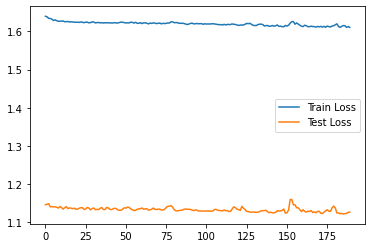

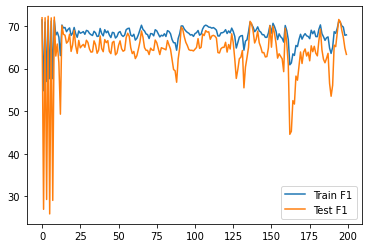

In [29]:
import matplotlib.pyplot as plt

plt.plot(train_loss[10::], label = "Train Loss")
plt.plot(test_loss[10::], label = "Test Loss")
plt.legend()
plt.show()
plt.plot(train_f1, label = "Train F1")
plt.plot(test_f1, label = "Test F1")
plt.legend()
plt.show()

# Test

In [30]:
import matplotlib.pyplot as plt
import torch

In [31]:
sm_net = torch.load("./pretrained/rating_video_text.pth")

In [ ]:
prs = []
rec = []
f1 = []

for i in np.arange(3, 4, 0.1):
    _, p, r, f, _, _, _ = sm_net.evaluate(i)
    prs.append(p)
    rec.append(r)
    f1.append(f)
    
plt.plot(prs, label = "Test Precision")
plt.plot(rec, label = "Test Recall")
plt.plot(f1, label = "Test F1")

plt.legend()
plt.show()

tensor([[3.2491],
        [3.2559],
        [3.2479],
        ...,
        [3.3726],
        [3.0379],
        [3.9105]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.83      0.05      0.09      8765
           1       0.57      0.99      0.73     11235

    accuracy                           0.58     20000
   macro avg       0.70      0.52      0.41     20000
weighted avg       0.68      0.58      0.45     20000



In [ ]:
prs

In [ ]:
rec